In [ ]:
#default_exp experiments

# Experiments

> refactor modelling, experiment functionality

In [ ]:
#export
from torchtools.core import *
from torchtools.data import *
from torchtools.models import *
from torchtools.datasets import *
from torchtools.augmentations import *
from torchtools.datablock import *
from torchtools.dataloader import *

In [ ]:
import pandas as pd
import numpy as np
from fastai2.basics import *

### Workflow

- load data frame
- create a configuration: x_cols, y_cols [n_train optional]
- create X,y from df and configuration
- create splits and transforms
- create dsets
- define batch tranforms
- create dlets from datasets
- define loss and model
- create Learner -> learn

In [ ]:
nrows=200000
df_main = pd.read_csv('./data/custom/bi_sample_anon.csv', nrows=nrows)

In [ ]:
## simple config
x_cols = [[f'x{i}_{j}' for j in range(10)] for i in range(6)]
dep = 'y0'
n_train = 8000

In [ ]:
#export
def items_to_arrays(items):
    '''convert list of item tuples into X,y numpy arrays (for use with numpy dataloader)'''
#     return np.stack([x[0] for x in items]), np.stack([x[1] for x in items])
    return tuple(np.stack([x[i] for x in items]) for i in range(len(items[0])))

In [ ]:
items = df_to_items(df_main, x_cols, dep, n_train)[0]
X,y = items_to_arrays(items)

(200000, 6, 10)


In [ ]:
splits = FixedSplitter(n_train, n_train+5000)(df_main)
splits = FixedSplitter(120000, 160000)(df_main)

tfms = [None, None]

In [ ]:
L(splits).map(len)

(#2) [120000,40000]

In [ ]:
dsets = TSDatasets2(X=X, y=y, tfms=tfms, splits=splits, inplace=True)

[<class 'torchtools.data.TSTensor'>, None]


In [ ]:
aug_tfms = all_noise_augs(magnitude=0.4, verbose=True)+all_erasing_augs(
    magnitude=0.4, verbose=True)+all_zoom_augs(magnitude=0.4, verbose=True)

In [ ]:
# norm = TSNormalize(by_sample=False, by_var=True)
ss = TSStandardize(by_sample=False, by_var=True, verbose=True)
norm = TSNormalize(by_sample=False, by_var=True, verbose=True)


augs = TimestepZero(verbose=True)
augs = RandAugment(N=3, magnitude=0.4, tfms=aug_tfms)


tfms [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , TimeNormal: (TSTensor,object) -> encodes , Dimout: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , Cutout: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , TimestepZero: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , Crop: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , RandomCrop: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , Maskout: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , Zoomin: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , Zoomout: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , RandZoom: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , RandTimesteps:

In [ ]:
# %%time
# dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[256, 512], num_workers=0)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[256, 512], num_workers=0, 
#                                after_batch=[TSNormalize(by_var=False)
#                                after_batch=Pipeline(noop), ##??
                               batch_tfms=[ss, augs],
#                                batch_tfms=[norm, augs]
                               
#                                batch_tfms=[norm]
                              )

[<class 'torchtools.data.TSTensor'>, None]
[<class 'torchtools.data.TSTensor'>, None]
TSStandardize setup mean=None, std=None, by_sample=False, by_var=True
mean: tensor([[[-1.3464],
         [-1.4978],
         [ 0.0117],
         [-1.7581],
         [-1.9539],
         [-0.0117]]])  std: tensor([[[86.8401],
         [89.4383],
         [ 1.7140],
         [86.1442],
         [89.4364],
         [ 1.7140]]])



In [ ]:
xb, yb = dls.one_batch()

standardize encodes
randtimestep
zoomin
ywarp


In [ ]:
xb.shape, type(xb)

(torch.Size([256, 6, 10]), torchtools.data.TSTensor)

In [ ]:
type(yb), type(xb)

(torch.Tensor, torchtools.data.TSTensor)

In [ ]:
set_seed(1234)
model = InceptionTimeSgm(6,1)
# model = InceptionTimeSgmOld(6,1)
# model = InceptionTime(6,1)

# loss_fn = F.cross_entropy
loss_fn = get_loss_fn('leaky_loss', alpha=0.5)
# loss_fn = F.mse_loss
# loss_fn = nll_leaky_loss

In [ ]:
learn = Learner(dls, model=model, loss_func=loss_fn, metrics=unweighted_profit)

In [ ]:
model(xb).shape

torch.Size([256, 1])

In [ ]:
unweighted_profit(model(xb), yb)

tensor(-1.0739, device='cuda:0')

In [ ]:
lr = 1e-5
wd = 0.03
epochs = 1
learn.fit_one_cycle(epochs, lr_max=lr, wd=wd)

epoch,train_loss,valid_loss,unweighted_profit,time
0,-0.194956,-0.097872,-0.008146,00:35


standardize encodes
randzoom
zoomin
ywarp
standardize encodes
ynormal
zoomout
maskout
standardize encodes
maskout
cutout
crop
standardize encodes
zoomin
zoomout
yscale
standardize encodes
timestepzero
randtimestep
timewarp
standardize encodes
crop
yscale
ywarp
standardize encodes
randzoom
crop
randomcrop
standardize encodes
ynormal
yscale
ywarp
standardize encodes
crop
timestepzero
timenormal torch.Size([256, 6, 10])
standardize encodes
timenormal torch.Size([256, 6, 10])
randomcrop
zoomout
standardize encodes
randomcrop
zoomout
yscale
standardize encodes
cutout
timenormal torch.Size([256, 6, 10])
randzoom
standardize encodes
randzoom
dimout
randtimestep
standardize encodes
randzoom
timestepzero
dimout
standardize encodes
ywarp
randzoom
ynormal
standardize encodes
timewarp
zoomin
randtimestep
standardize encodes
ynormal
randomcrop
timestepzero
standardize encodes
ynormal
randomcrop
randtimestep
standardize encodes
yscale
zoomout
ywarp
standardize encodes
randzoom
maskout
cutout
standar

standardize encodes
ynormal
timestepzero
maskout
standardize encodes
timestepzero
cutout
randzoom
standardize encodes
timestepzero
timenormal torch.Size([256, 6, 10])
ywarp
standardize encodes
timewarp
timenormal torch.Size([256, 6, 10])
ynormal
standardize encodes
timewarp
zoomout
randomcrop
standardize encodes
randomcrop
dimout
timestepzero
standardize encodes
ynormal
randomcrop
zoomout
standardize encodes
ynormal
timenormal torch.Size([256, 6, 10])
zoomin
standardize encodes
timenormal torch.Size([256, 6, 10])
timewarp
randomcrop
standardize encodes
timenormal torch.Size([256, 6, 10])
randzoom
ynormal
standardize encodes
zoomout
crop
zoomin
standardize encodes
maskout
ywarp
dimout
standardize encodes
dimout
ywarp
randtimestep
standardize encodes
timestepzero
randzoom
ynormal
standardize encodes
zoomin
crop
cutout
standardize encodes
yscale
timenormal torch.Size([256, 6, 10])
zoomout
standardize encodes
timenormal torch.Size([256, 6, 10])
maskout
timestepzero
standardize encodes
crop

standardize encodes
randzoom
crop
maskout
standardize encodes
timestepzero
maskout
randomcrop
standardize encodes
timestepzero
zoomout
ynormal
standardize encodes
cutout
zoomout
randzoom
standardize encodes
ywarp
timewarp
zoomin
standardize encodes
ynormal
randzoom
zoomout
standardize encodes
maskout
randzoom
yscale
standardize encodes
crop
timenormal torch.Size([256, 6, 10])
ynormal
standardize encodes
cutout
timestepzero
timewarp
standardize encodes
maskout
randtimestep
randzoom
standardize encodes
zoomout
zoomin
randtimestep
standardize encodes
timenormal torch.Size([256, 6, 10])
zoomin
ynormal
standardize encodes
randomcrop
dimout
cutout
standardize encodes
ynormal
timestepzero
zoomin
standardize encodes
randtimestep
maskout
randomcrop
standardize encodes
dimout
randzoom
crop
standardize encodes
zoomin
yscale
ywarp
standardize encodes
timestepzero
timewarp
dimout
standardize encodes
randomcrop
randzoom
maskout
standardize encodes
timestepzero
randtimestep
zoomout
standardize encode

standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes


In [ ]:
unweighted_profit(model(xb), yb)

tensor(0.1725, device='cuda:0')

In [ ]:
preds, y_true = learn.get_preds()

standardize encodes


standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes


In [ ]:
unweighted_profit(preds, y_true)

tensor(-0.0279)

In [ ]:
preds.max()

tensor(0.1916)

In [ ]:
preds.shape

torch.Size([40000, 1])

(array([2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00, 4.000e+00, 6.000e+00, 6.000e+00, 1.000e+01, 1.200e+01,
        1.100e+01, 1.500e+01, 2.500e+01, 1.500e+01, 1.800e+01, 2.200e+01,
        2.900e+01, 4.300e+01, 4.200e+01, 5.200e+01, 4.900e+01, 6.600e+01,
        7.100e+01, 8.500e+01, 1.130e+02, 1.060e+02, 1.500e+02, 1.410e+02,
        1.760e+02, 2.290e+02, 2.390e+02, 2.670e+02, 3.170e+02, 3.720e+02,
        3.970e+02, 4.430e+02, 4.760e+02, 5.040e+02, 6.250e+02, 6.970e+02,
        6.960e+02, 8.260e+02, 8.620e+02, 9.280e+02, 1.034e+03, 1.058e+03,
        1.140e+03, 1.177e+03, 1.202e+03, 1.203e+03, 1.257e+03, 1.286e+03,
        1.413e+03, 1.394e+03, 1.273e+03, 1.333e+03, 1.245e+03, 1.292e+03,
        1.185e+03, 1.176e+03, 1.152e+03, 1.055e+03, 9.580e+02, 9.420e+02,
        9.020e+02, 7.350e+02, 6.810e+02, 6.670e+02, 5.770e+02, 5.410e+02,
        4.610e+02, 3.840e+02, 3.510e+02, 2.820e+02, 2.530e+02, 2.130e+02,
        2.020e+02, 1.470e+02, 1.300e+0

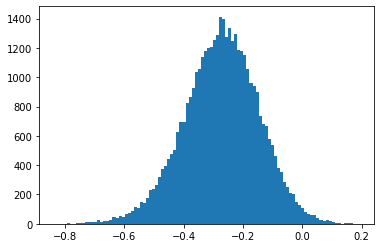

In [ ]:
plt.hist(preds.squeeze().cpu().numpy(), bins=100)

In [ ]:
lr = 3e-5
wd = 0.03
epochs = 20
learn.fit_one_cycle(epochs, lr_max=lr, wd=wd)

epoch,train_loss,valid_loss,unweighted_profit,time
0,-0.091273,-0.123785,-0.046582,00:40
1,-0.229820,-0.171957,-0.026458,00:37
2,-0.405801,-0.262996,-0.059819,00:37
3,-0.338075,-0.384389,-0.025922,00:37
4,-0.350717,-0.426830,0.052660,00:37
5,-0.669083,-0.499907,0.128003,00:38
6,-0.286783,-0.518230,-0.040948,00:39
7,-0.495091,-0.552125,0.170119,00:39
8,-0.733524,-0.580903,0.034508,00:38
9,-0.513051,-0.576941,0.014500,00:37


standardize encodes
randzoom
zoomin
ywarp
standardize encodes
ynormal
zoomout
maskout
standardize encodes
maskout
cutout
crop
standardize encodes
zoomin
zoomout
yscale
standardize encodes
timestepzero
randtimestep
timewarp
standardize encodes
crop
yscale
ywarp
standardize encodes
randzoom
crop
randomcrop
standardize encodes
ynormal
yscale
ywarp
standardize encodes
crop
timestepzero
timenormal torch.Size([256, 6, 10])
standardize encodes
timenormal torch.Size([256, 6, 10])
randomcrop
zoomout
standardize encodes
randomcrop
zoomout
yscale
standardize encodes
cutout
timenormal torch.Size([256, 6, 10])
randzoom
standardize encodes
randzoom
dimout
randtimestep
standardize encodes
randzoom
timestepzero
dimout
standardize encodes
ywarp
randzoom
ynormal
standardize encodes
timewarp
zoomin
randtimestep
standardize encodes
ynormal
randomcrop
timestepzero
standardize encodes
ynormal
randomcrop
randtimestep
standardize encodes
yscale
zoomout
ywarp
standardize encodes
randzoom
maskout
cutout
standar

standardize encodes
ynormal
timestepzero
maskout
standardize encodes
timestepzero
cutout
randzoom
standardize encodes
timestepzero
timenormal torch.Size([256, 6, 10])
ywarp
standardize encodes
timewarp
timenormal torch.Size([256, 6, 10])
ynormal
standardize encodes
timewarp
zoomout
randomcrop
standardize encodes
randomcrop
dimout
timestepzero
standardize encodes
ynormal
randomcrop
zoomout
standardize encodes
ynormal
timenormal torch.Size([256, 6, 10])
zoomin
standardize encodes
timenormal torch.Size([256, 6, 10])
timewarp
randomcrop
standardize encodes
timenormal torch.Size([256, 6, 10])
randzoom
ynormal
standardize encodes
zoomout
crop
zoomin
standardize encodes
maskout
ywarp
dimout
standardize encodes
dimout
ywarp
randtimestep
standardize encodes
timestepzero
randzoom
ynormal
standardize encodes
zoomin
crop
cutout
standardize encodes
yscale
timenormal torch.Size([256, 6, 10])
zoomout
standardize encodes
timenormal torch.Size([256, 6, 10])
maskout
timestepzero
standardize encodes
crop

standardize encodes
randzoom
crop
maskout
standardize encodes
timestepzero
maskout
randomcrop
standardize encodes
timestepzero
zoomout
ynormal
standardize encodes
cutout
zoomout
randzoom
standardize encodes
ywarp
timewarp
zoomin
standardize encodes
ynormal
randzoom
zoomout
standardize encodes
maskout
randzoom
yscale
standardize encodes
crop
timenormal torch.Size([256, 6, 10])
ynormal
standardize encodes
cutout
timestepzero
timewarp
standardize encodes
maskout
randtimestep
randzoom
standardize encodes
zoomout
zoomin
randtimestep
standardize encodes
timenormal torch.Size([256, 6, 10])
zoomin
ynormal
standardize encodes
randomcrop
dimout
cutout
standardize encodes
ynormal
timestepzero
zoomin
standardize encodes
randtimestep
maskout
randomcrop
standardize encodes
dimout
randzoom
crop
standardize encodes
zoomin
yscale
ywarp
standardize encodes
timestepzero
timewarp
dimout
standardize encodes
randomcrop
randzoom
maskout
standardize encodes
timestepzero
randtimestep
zoomout
standardize encode

standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
yscale
randomcrop
zoomout
standardize encodes
randtimestep
zoomin
ynormal
standardize encodes
timestepzero
dimout
zoomin
standardize encodes
dimout
maskout
crop

dimout
timestepzero
standardize encodes
maskout
yscale
zoomin
standardize encodes
yscale
randzoom
timestepzero
standardize encodes
zoomout
yscale
crop
standardize encodes
dimout
zoomout
randomcrop
standardize encodes
timenormal torch.Size([256, 6, 10])
ywarp
yscale
standardize encodes
timewarp
dimout
timenormal torch.Size([256, 6, 10])
standardize encodes
randzoom
cutout
randtimestep
standardize encodes
randtimestep
ywarp
yscale
standardize encodes
ywarp
timestepzero
timenormal torch.Size([256, 6, 10])
standardize encodes
randomcrop
ynormal
randtimestep
standardize encodes
ywarp
timestepzero
randzoom
standardize encodes
timestepzero
yscale
timewarp
standardize encodes
maskout
zoomin
ywarp
standardize encodes
ywarp
yscale
maskout
standardize encodes
randomcrop
randzoom
ynormal
standardize encodes
randtimestep
ywarp
yscale
standardize encodes
dimout
maskout
randtimestep
standardize encodes
timestepzero
randzoom
timenormal torch.Size([256, 6, 10])
standardize encodes
ynormal
zoomin
dimout

standardize encodes
maskout
zoomout
timenormal torch.Size([256, 6, 10])
standardize encodes
maskout
cutout
randzoom
standardize encodes
ynormal
randzoom
zoomin
standardize encodes
yscale
randomcrop
maskout
standardize encodes
timenormal torch.Size([256, 6, 10])
zoomin
crop
standardize encodes
yscale
timestepzero
maskout
standardize encodes
zoomout
randzoom
timewarp
standardize encodes
randtimestep
zoomout
timestepzero
standardize encodes
timewarp
randomcrop
ynormal
standardize encodes
dimout
timenormal torch.Size([256, 6, 10])
timestepzero
standardize encodes
zoomin
timenormal torch.Size([256, 6, 10])
timewarp
standardize encodes
randtimestep
zoomout
randzoom
standardize encodes
zoomin
timenormal torch.Size([256, 6, 10])
maskout
standardize encodes
timewarp
crop
dimout
standardize encodes
timestepzero
crop
randzoom
standardize encodes
zoomin
randomcrop
timestepzero
standardize encodes
timenormal torch.Size([256, 6, 10])
zoomout
randtimestep
standardize encodes
timenormal torch.Size([25

standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes


standardize encodes
ywarp
zoomin
cutout
standardize encodes
timewarp
zoomout
timenormal torch.Size([256, 6, 10])
standardize encodes
timestepzero
crop
cutout
standardize encodes
zoomout
timenormal torch.Size([256, 6, 10])
ywarp
standardize encodes
timestepzero
yscale
ynormal
standardize encodes
timenormal torch.Size([256, 6, 10])
yscale
randzoom
standardize encodes
crop
timewarp
randomcrop
standardize encodes
cutout
randzoom
zoomin
standardize encodes
randtimestep
timestepzero
zoomin
standardize encodes
randomcrop
timenormal torch.Size([256, 6, 10])
ywarp
standardize encodes
ywarp
crop
randzoom
standardize encodes
ywarp
randzoom
randtimestep
standardize encodes
ynormal
ywarp
cutout
standardize encodes
zoomout
ywarp
crop
standardize encodes
yscale
ywarp
dimout
standardize encodes
timewarp
zoomin
crop
standardize encodes
ywarp
zoomin
ynormal
standardize encodes
crop
ywarp
timenormal torch.Size([256, 6, 10])
standardize encodes
zoomin
timewarp
ywarp
standardize encodes
maskout
randtimeste

standardize encodes
ynormal
maskout
crop
standardize encodes
ynormal
zoomin
timewarp
standardize encodes
zoomin
crop
randzoom
standardize encodes
yscale
maskout
ywarp
standardize encodes
timenormal torch.Size([256, 6, 10])
yscale
ynormal
standardize encodes
yscale
cutout
randzoom
standardize encodes
ynormal
randomcrop
zoomin
standardize encodes
zoomout
timenormal torch.Size([256, 6, 10])
crop
standardize encodes
ywarp
dimout
zoomin
standardize encodes
ywarp
randzoom
timestepzero
standardize encodes
randomcrop
randzoom
dimout
standardize encodes
yscale
cutout
zoomout
standardize encodes
timestepzero
cutout
zoomout
standardize encodes
crop
cutout
zoomout
standardize encodes
randzoom
ywarp
zoomin
standardize encodes
timenormal torch.Size([256, 6, 10])
randomcrop
zoomout
standardize encodes
maskout
ynormal
timestepzero
standardize encodes
randtimestep
cutout
maskout
standardize encodes
randzoom
ywarp
randomcrop
standardize encodes
crop
ynormal
randtimestep
standardize encodes
ynormal
zoomo

standardize encodes
randomcrop
zoomout
timewarp
standardize encodes
ywarp
randzoom
crop
standardize encodes
ynormal
ywarp
cutout
standardize encodes
randzoom
ynormal
ywarp
standardize encodes
ywarp
zoomout
yscale
standardize encodes
dimout
maskout
zoomin
standardize encodes
timestepzero
timenormal torch.Size([256, 6, 10])
yscale
standardize encodes
timestepzero
maskout
crop
standardize encodes
ywarp
randtimestep
cutout
standardize encodes
ywarp
dimout
randtimestep
standardize encodes
randomcrop
zoomout
randtimestep
standardize encodes
cutout
timestepzero
maskout
standardize encodes
randomcrop
timewarp
ynormal
standardize encodes
dimout
zoomout
ynormal
standardize encodes
randzoom
timewarp
cutout
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize enc

standardize encodes
crop
timestepzero
timenormal torch.Size([256, 6, 10])
standardize encodes
timestepzero
maskout
randzoom
standardize encodes
randzoom
timenormal torch.Size([256, 6, 10])
ynormal
standardize encodes
timewarp
ynormal
zoomout
standardize encodes
zoomin
ynormal
timestepzero
standardize encodes
timewarp
randzoom
crop
standardize encodes
randomcrop
zoomin
ynormal
standardize encodes
ywarp
randtimestep
randzoom
standardize encodes
randzoom
zoomout
crop
standardize encodes
ywarp
randtimestep
dimout
standardize encodes
randomcrop
yscale
timewarp
standardize encodes
zoomin
timestepzero
crop
standardize encodes
ywarp
randomcrop
cutout
standardize encodes
timestepzero
ynormal
dimout
standardize encodes
zoomin
timenormal torch.Size([256, 6, 10])
timestepzero
standardize encodes
maskout
timenormal torch.Size([256, 6, 10])
ynormal
standardize encodes
ywarp
cutout
maskout
standardize encodes
zoomin
ywarp
randtimestep
standardize encodes
randtimestep
dimout
cutout
standardize encodes

zoomin
dimout
standardize encodes
randtimestep
maskout
timewarp
standardize encodes
randtimestep
dimout
timewarp
standardize encodes
dimout
timestepzero
yscale
standardize encodes
randtimestep
dimout
ywarp
standardize encodes
dimout
ywarp
zoomout
standardize encodes
ynormal
randzoom
yscale
standardize encodes
timenormal torch.Size([256, 6, 10])
zoomout
zoomin
standardize encodes
randzoom
timestepzero
yscale
standardize encodes
ynormal
cutout
timestepzero
standardize encodes
maskout
ynormal
ywarp
standardize encodes
maskout
timestepzero
dimout
standardize encodes
dimout
randzoom
cutout
standardize encodes
timenormal torch.Size([256, 6, 10])
randzoom
randtimestep
standardize encodes
dimout
crop
cutout
standardize encodes
timestepzero
maskout
timenormal torch.Size([256, 6, 10])
standardize encodes
cutout
yscale
timestepzero
standardize encodes
crop
randzoom
randtimestep
standardize encodes
ywarp
ynormal
zoomin
standardize encodes
ynormal
crop
zoomin
standardize encodes
timewarp
ynormal
ti

standardize encodes
timestepzero
ywarp
dimout
standardize encodes
randomcrop
randzoom
timenormal torch.Size([256, 6, 10])
standardize encodes
dimout
randomcrop
cutout
standardize encodes
randzoom
timewarp
dimout
standardize encodes
yscale
crop
randtimestep
standardize encodes
crop
cutout
randomcrop
standardize encodes
yscale
cutout
zoomout
standardize encodes
maskout
zoomout
randzoom
standardize encodes
zoomin
ywarp
dimout
standardize encodes
randomcrop
crop
ynormal
standardize encodes
timewarp
randomcrop
randtimestep
standardize encodes
zoomout
crop
timewarp
standardize encodes
timestepzero
ynormal
crop
standardize encodes
ynormal
dimout
crop
standardize encodes
ywarp
cutout
ynormal
standardize encodes
zoomout
randomcrop
ywarp
standardize encodes
cutout
randomcrop
randzoom
standardize encodes
yscale
randzoom
dimout
standardize encodes
cutout
randzoom
maskout
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standard

standardize encodes
timestepzero
ynormal
yscale
standardize encodes
timewarp
crop
timenormal torch.Size([256, 6, 10])
standardize encodes
zoomout
randomcrop
cutout
standardize encodes
zoomout
randomcrop
cutout
standardize encodes
timewarp
maskout
crop
standardize encodes
timenormal torch.Size([256, 6, 10])
randzoom
crop
standardize encodes
randtimestep
maskout
timenormal torch.Size([256, 6, 10])
standardize encodes
timenormal torch.Size([256, 6, 10])
timewarp
randtimestep
standardize encodes
maskout
timewarp
crop
standardize encodes
randomcrop
timenormal torch.Size([256, 6, 10])
yscale
standardize encodes
timenormal torch.Size([256, 6, 10])
crop
yscale
standardize encodes
randzoom
cutout
randomcrop
standardize encodes
randtimestep
maskout
randomcrop
standardize encodes
timestepzero
crop
randzoom
standardize encodes
zoomin
randomcrop
maskout
standardize encodes
randomcrop
randzoom
dimout
standardize encodes
randomcrop
randzoom
cutout
standardize encodes
cutout
crop
randomcrop
standardiz

randomcrop
maskout
standardize encodes
dimout
cutout
yscale
standardize encodes
timestepzero
randtimestep
zoomin
standardize encodes
yscale
maskout
timestepzero
standardize encodes
crop
timestepzero
ynormal
standardize encodes
maskout
zoomout
ynormal
standardize encodes
randtimestep
randomcrop
yscale
standardize encodes
crop
zoomout
randomcrop
standardize encodes
timenormal torch.Size([256, 6, 10])
maskout
dimout
standardize encodes
dimout
yscale
ywarp
standardize encodes
timewarp
dimout
randomcrop
standardize encodes
cutout
zoomout
randzoom
standardize encodes
timewarp
cutout
ywarp
standardize encodes
ynormal
ywarp
timenormal torch.Size([256, 6, 10])
standardize encodes
crop
ywarp
randtimestep
standardize encodes
ywarp
randzoom
timenormal torch.Size([256, 6, 10])
standardize encodes
timenormal torch.Size([256, 6, 10])
ynormal
dimout
standardize encodes
ywarp
randzoom
ynormal
standardize encodes
yscale
timestepzero
ywarp
standardize encodes
crop
cutout
ynormal
standardize encodes
timen

standardize encodes
randtimestep
randomcrop
timewarp
standardize encodes
randomcrop
zoomout
timewarp
standardize encodes
timestepzero
timewarp
dimout
standardize encodes
timenormal torch.Size([256, 6, 10])
ynormal
zoomin
standardize encodes
ynormal
dimout
yscale
standardize encodes
ywarp
yscale
zoomin
standardize encodes
crop
randtimestep
dimout
standardize encodes
randomcrop
ynormal
maskout
standardize encodes
zoomout
ywarp
yscale
standardize encodes
ynormal
timewarp
zoomout
standardize encodes
zoomin
yscale
randzoom
standardize encodes
randzoom
ynormal
cutout
standardize encodes
ynormal
cutout
maskout
standardize encodes
ywarp
maskout
randomcrop
standardize encodes
timewarp
crop
zoomin
standardize encodes
randomcrop
yscale
randzoom
standardize encodes
cutout
yscale
dimout
standardize encodes
timestepzero
crop
yscale
standardize encodes
ywarp
crop
timewarp
standardize encodes
ywarp
crop
zoomout
standardize encodes
maskout
timewarp
zoomin
standardize encodes
dimout
maskout
randzoom
sta

standardize encodes
timewarp
crop
maskout
standardize encodes
randomcrop
zoomout
yscale
standardize encodes
randomcrop
yscale
dimout
standardize encodes
timestepzero
timenormal torch.Size([256, 6, 10])
dimout
standardize encodes
randomcrop
timenormal torch.Size([256, 6, 10])
crop
standardize encodes
maskout
ywarp
dimout
standardize encodes
ywarp
zoomout
cutout
standardize encodes
zoomout
cutout
timenormal torch.Size([256, 6, 10])
standardize encodes
timewarp
ynormal
zoomin
standardize encodes
zoomin
yscale
randomcrop
standardize encodes
ywarp
maskout
randomcrop
standardize encodes
timewarp
crop
zoomout
standardize encodes
crop
yscale
randzoom
standardize encodes
dimout
crop
ywarp
standardize encodes
ynormal
zoomout
randzoom
standardize encodes
dimout
yscale
maskout
standardize encodes
zoomin
timenormal torch.Size([256, 6, 10])
cutout
standardize encodes
randzoom
ywarp
timewarp
standardize encodes
zoomout
zoomin
timewarp
standardize encodes
cutout
randomcrop
timewarp
standardize encodes

standardize encodes
dimout
timenormal torch.Size([256, 6, 10])
cutout
standardize encodes
dimout
zoomin
randomcrop
standardize encodes
timenormal torch.Size([256, 6, 10])
timewarp
yscale
standardize encodes
randzoom
randtimestep
yscale
standardize encodes
timewarp
dimout
maskout
standardize encodes
crop
timewarp
randtimestep
standardize encodes
crop
timewarp
randomcrop
standardize encodes
cutout
yscale
crop
standardize encodes
zoomin
timewarp
randomcrop
standardize encodes
timestepzero
crop
randomcrop
standardize encodes
timewarp
ynormal
dimout
standardize encodes
randzoom
randtimestep
cutout
standardize encodes
yscale
zoomin
ynormal
standardize encodes
timestepzero
randzoom
ywarp
standardize encodes
timestepzero
yscale
crop
standardize encodes
zoomout
timenormal torch.Size([256, 6, 10])
randtimestep
standardize encodes
cutout
ynormal
zoomout
standardize encodes
yscale
ywarp
randzoom
standardize encodes
dimout
ywarp
randzoom
standardize encodes
timestepzero
crop
timewarp
standardize en

standardize encodes
randtimestep
timewarp
randomcrop
standardize encodes
randzoom
crop
zoomin
standardize encodes
cutout
zoomout
randtimestep
standardize encodes
yscale
timestepzero
zoomout
standardize encodes
maskout
cutout
crop
standardize encodes
timenormal torch.Size([256, 6, 10])
timestepzero
timewarp
standardize encodes
maskout
randzoom
randtimestep
standardize encodes
ynormal
timenormal torch.Size([256, 6, 10])
randomcrop
standardize encodes
dimout
randzoom
randomcrop
standardize encodes
crop
maskout
cutout
standardize encodes
ywarp
cutout
timestepzero
standardize encodes
randtimestep
yscale
crop
standardize encodes
timenormal torch.Size([256, 6, 10])
ywarp
maskout
standardize encodes
zoomin
crop
yscale
standardize encodes
crop
randtimestep
cutout
standardize encodes
dimout
zoomout
crop
standardize encodes
dimout
randomcrop
randtimestep
standardize encodes
zoomout
timenormal torch.Size([256, 6, 10])
crop
standardize encodes
zoomin
ywarp
dimout
standardize encodes
zoomin
ywarp
ra

standardize encodes
zoomin
randzoom
timenormal torch.Size([256, 6, 10])
standardize encodes
crop
dimout
ynormal
standardize encodes
randzoom
cutout
randtimestep
standardize encodes
timewarp
zoomout
randtimestep
standardize encodes
timewarp
timestepzero
timenormal torch.Size([256, 6, 10])
standardize encodes
timewarp
ynormal
timenormal torch.Size([256, 6, 10])
standardize encodes
randtimestep
cutout
timenormal torch.Size([256, 6, 10])
standardize encodes
ywarp
cutout
randomcrop
standardize encodes
crop
randtimestep
dimout
standardize encodes
timewarp
cutout
yscale
standardize encodes
yscale
maskout
dimout
standardize encodes
timestepzero
crop
yscale
standardize encodes
yscale
dimout
randzoom
standardize encodes
randomcrop
zoomout
cutout
standardize encodes
dimout
cutout
timenormal torch.Size([256, 6, 10])
standardize encodes
cutout
crop
dimout
standardize encodes
randtimestep
yscale
randzoom
standardize encodes
ynormal
crop
yscale
standardize encodes
cutout
timenormal torch.Size([256, 6

standardize encodes
zoomin
zoomout
randzoom
standardize encodes
randomcrop
maskout
ywarp
standardize encodes
ywarp
cutout
randtimestep
standardize encodes
dimout
ynormal
randzoom
standardize encodes
zoomin
randtimestep
timestepzero
standardize encodes
zoomout
cutout
ynormal
standardize encodes
zoomout
ynormal
cutout
standardize encodes
timestepzero
zoomout
crop
standardize encodes
timewarp
yscale
maskout
standardize encodes
zoomin
ynormal
ywarp
standardize encodes
randomcrop
cutout
crop
standardize encodes
zoomout
timewarp
ywarp
standardize encodes
randomcrop
cutout
timenormal torch.Size([256, 6, 10])
standardize encodes
timenormal torch.Size([256, 6, 10])
zoomin
ywarp
standardize encodes
randtimestep
timestepzero
ynormal
standardize encodes
ywarp
zoomin
yscale
standardize encodes
maskout
yscale
cutout
standardize encodes
cutout
zoomin
timestepzero
standardize encodes
dimout
yscale
crop
standardize encodes
randtimestep
crop
ynormal
standardize encodes
ywarp
timewarp
cutout
standardize 

standardize encodes
ynormal
yscale
randzoom
standardize encodes
zoomout
timewarp
ywarp
standardize encodes
randomcrop
randzoom
ywarp
standardize encodes
cutout
yscale
zoomin
standardize encodes
dimout
ywarp
crop
standardize encodes
ywarp
randomcrop
zoomout
standardize encodes
timestepzero
ynormal
zoomout
standardize encodes
ynormal
cutout
randtimestep
standardize encodes
zoomin
timenormal torch.Size([256, 6, 10])
dimout
standardize encodes
cutout
timestepzero
crop
standardize encodes
ynormal
ywarp
timewarp
standardize encodes
zoomout
randzoom
maskout
standardize encodes
timestepzero
zoomin
yscale
standardize encodes
randomcrop
timewarp
timenormal torch.Size([256, 6, 10])
standardize encodes
randzoom
maskout
dimout
standardize encodes
ywarp
randomcrop
dimout
standardize encodes
randomcrop
zoomin
maskout
standardize encodes
maskout
timewarp
yscale
standardize encodes
dimout
timewarp
ywarp
standardize encodes
ywarp
zoomout
randomcrop
standardize encodes
ynormal
yscale
zoomin
standardize e

standardize encodes
dimout
cutout
randzoom
standardize encodes
timenormal torch.Size([256, 6, 10])
randzoom
randomcrop
standardize encodes
yscale
randomcrop
zoomout
standardize encodes
zoomin
timestepzero
dimout
standardize encodes
zoomout
crop
yscale
standardize encodes
randtimestep
dimout
ynormal
standardize encodes
timewarp
ywarp
ynormal
standardize encodes
crop
timestepzero
randomcrop
standardize encodes
ywarp
timenormal torch.Size([256, 6, 10])
randomcrop
standardize encodes
timestepzero
randtimestep
ynormal
standardize encodes
timenormal torch.Size([256, 6, 10])
cutout
randtimestep
standardize encodes
maskout
dimout
ywarp
standardize encodes
ynormal
crop
zoomout
standardize encodes
yscale
timenormal torch.Size([256, 6, 10])
ynormal
standardize encodes
randomcrop
zoomin
zoomout
standardize encodes
timestepzero
crop
ynormal
standardize encodes
dimout
zoomin
randzoom
standardize encodes
ynormal
randtimestep
timewarp
standardize encodes
crop
maskout
timestepzero
standardize encodes
z

standardize encodes
maskout
cutout
zoomout
standardize encodes
crop
randzoom
zoomin
standardize encodes
yscale
timenormal torch.Size([256, 6, 10])
zoomin
standardize encodes
zoomin
randzoom
timestepzero
standardize encodes
timestepzero
crop
randtimestep
standardize encodes
dimout
randomcrop
timenormal torch.Size([256, 6, 10])
standardize encodes
dimout
randomcrop
timestepzero
standardize encodes
randomcrop
crop
maskout
standardize encodes
randomcrop
zoomin
cutout
standardize encodes
ywarp
crop
maskout
standardize encodes
crop
cutout
yscale
standardize encodes
yscale
randomcrop
randtimestep
standardize encodes
ywarp
ynormal
randzoom
standardize encodes
ywarp
randzoom
yscale
standardize encodes
crop
randomcrop
maskout
standardize encodes
timestepzero
cutout
timenormal torch.Size([256, 6, 10])
standardize encodes
randtimestep
zoomin
maskout
standardize encodes
crop
timewarp
dimout
standardize encodes
randzoom
zoomout
yscale
standardize encodes
zoomout
maskout
ywarp
standardize encodes
ran

standardize encodes
randtimestep
timestepzero
cutout
standardize encodes
randomcrop
ynormal
zoomin
standardize encodes
randzoom
zoomin
maskout
standardize encodes
ywarp
randtimestep
cutout
standardize encodes
crop
zoomout
timenormal torch.Size([256, 6, 10])
standardize encodes
maskout
zoomin
yscale
standardize encodes
timenormal torch.Size([256, 6, 10])
randomcrop
maskout
standardize encodes
yscale
dimout
randomcrop
standardize encodes
randzoom
randtimestep
yscale
standardize encodes
timewarp
ywarp
maskout
standardize encodes
timenormal torch.Size([256, 6, 10])
zoomout
ynormal
standardize encodes
zoomin
cutout
ywarp
standardize encodes
ywarp
timestepzero
randzoom
standardize encodes
timestepzero
timenormal torch.Size([256, 6, 10])
ywarp
standardize encodes
dimout
timenormal torch.Size([256, 6, 10])
randtimestep
standardize encodes
crop
randzoom
timestepzero
standardize encodes
timewarp
timestepzero
randzoom
standardize encodes
dimout
yscale
crop
standardize encodes
yscale
ynormal
times

standardize encodes
maskout
timewarp
dimout
standardize encodes
maskout
ywarp
dimout
standardize encodes
timewarp
zoomin
crop
standardize encodes
yscale
ywarp
crop
standardize encodes
randomcrop
timenormal torch.Size([256, 6, 10])
ynormal
standardize encodes
maskout
randzoom
timestepzero
standardize encodes
ynormal
zoomout
maskout
standardize encodes
zoomout
ynormal
zoomin
standardize encodes
randzoom
timenormal torch.Size([256, 6, 10])
cutout
standardize encodes
randtimestep
crop
ywarp
standardize encodes
randomcrop
crop
randzoom
standardize encodes
timestepzero
yscale
timenormal torch.Size([256, 6, 10])
standardize encodes
yscale
randzoom
maskout
standardize encodes
zoomin
cutout
ynormal
standardize encodes
ynormal
randomcrop
timewarp
standardize encodes
timewarp
zoomout
timenormal torch.Size([256, 6, 10])
standardize encodes
yscale
ywarp
maskout
standardize encodes
randomcrop
crop
timenormal torch.Size([256, 6, 10])
standardize encodes
timestepzero
ywarp
timenormal torch.Size([256, 

standardize encodes
timenormal torch.Size([256, 6, 10])
dimout
yscale
standardize encodes
yscale
zoomout
crop
standardize encodes
randzoom
yscale
zoomin
standardize encodes
randtimestep
randzoom
yscale
standardize encodes
yscale
randzoom
crop
standardize encodes
timestepzero
ynormal
randomcrop
standardize encodes
zoomin
timewarp
timenormal torch.Size([256, 6, 10])
standardize encodes
randzoom
ynormal
randomcrop
standardize encodes
crop
timestepzero
zoomout
standardize encodes
dimout
crop
randtimestep
standardize encodes
dimout
timestepzero
maskout
standardize encodes
randomcrop
ywarp
crop
standardize encodes
cutout
randomcrop
dimout
standardize encodes
maskout
zoomout
randzoom
standardize encodes
crop
timestepzero
maskout
standardize encodes
dimout
zoomin
zoomout
standardize encodes
timestepzero
ywarp
crop
standardize encodes
ynormal
timestepzero
yscale
standardize encodes
ywarp
timenormal torch.Size([256, 6, 10])
cutout
standardize encodes
crop
ynormal
cutout
standardize encodes
timen

standardize encodes
cutout
yscale
ynormal
standardize encodes
ynormal
ywarp
maskout
standardize encodes
cutout
crop
timestepzero
standardize encodes
cutout
zoomin
ynormal
standardize encodes
dimout
timewarp
yscale
standardize encodes
zoomout
timewarp
ynormal
standardize encodes
zoomout
maskout
timewarp
standardize encodes
randtimestep
ywarp
dimout
standardize encodes
randzoom
dimout
zoomin
standardize encodes
zoomout
crop
dimout
standardize encodes
randzoom
zoomin
ywarp
standardize encodes
yscale
crop
maskout
standardize encodes
randtimestep
randomcrop
zoomout
standardize encodes
dimout
yscale
cutout
standardize encodes
timewarp
randtimestep
zoomin
standardize encodes
yscale
cutout
timestepzero
standardize encodes
timenormal torch.Size([256, 6, 10])
zoomout
cutout
standardize encodes
zoomout
ywarp
zoomin
standardize encodes
ywarp
timenormal torch.Size([256, 6, 10])
timewarp
standardize encodes
dimout
timewarp
randzoom
standardize encodes
zoomin
ynormal
randomcrop
standardize encodes
cr

standardize encodes
timestepzero
yscale
randtimestep
standardize encodes
timestepzero
crop
zoomout
standardize encodes
randzoom
randtimestep
zoomout
standardize encodes
crop
cutout
yscale
standardize encodes
cutout
dimout
ywarp
standardize encodes
randomcrop
timewarp
maskout
standardize encodes
timenormal torch.Size([256, 6, 10])
randtimestep
crop
standardize encodes
ynormal
randzoom
crop
standardize encodes
randtimestep
randzoom
dimout
standardize encodes
timewarp
crop
timestepzero
standardize encodes
zoomin
yscale
randomcrop
standardize encodes
zoomin
randtimestep
yscale
standardize encodes
timewarp
dimout
randtimestep
standardize encodes
randzoom
timestepzero
crop
standardize encodes
dimout
ywarp
maskout
standardize encodes
randomcrop
ynormal
zoomin
standardize encodes
randomcrop
ynormal
yscale
standardize encodes
timewarp
zoomout
randzoom
standardize encodes
ynormal
timestepzero
crop
standardize encodes
ywarp
crop
randtimestep
standardize encodes
zoomout
crop
randzoom
standardize e

dimout
randzoom
yscale
standardize encodes
randzoom
timewarp
ywarp
standardize encodes
randomcrop
cutout
timenormal torch.Size([256, 6, 10])
standardize encodes
timestepzero
zoomin
randomcrop
standardize encodes
randomcrop
timenormal torch.Size([256, 6, 10])
ywarp
standardize encodes
randomcrop
cutout
maskout
standardize encodes
randzoom
timewarp
randtimestep
standardize encodes
randtimestep
zoomout
randomcrop
standardize encodes
ywarp
cutout
zoomout
standardize encodes
yscale
dimout
randzoom
standardize encodes
timestepzero
zoomin
cutout
standardize encodes
randzoom
zoomin
cutout
standardize encodes
randtimestep
timewarp
randzoom
standardize encodes
zoomout
crop
timenormal torch.Size([256, 6, 10])
standardize encodes
randomcrop
randzoom
cutout
standardize encodes
timewarp
cutout
timenormal torch.Size([256, 6, 10])
standardize encodes
ynormal
dimout
timenormal torch.Size([256, 6, 10])
standardize encodes
randtimestep
cutout
randzoom
standardize encodes
zoomin
maskout
zoomout
standardiz

standardize encodes
timestepzero
zoomout
timewarp
standardize encodes
randzoom
zoomin
maskout
standardize encodes
zoomin
zoomout
timenormal torch.Size([256, 6, 10])
standardize encodes
timestepzero
cutout
ywarp
standardize encodes
timenormal torch.Size([256, 6, 10])
ywarp
randomcrop
standardize encodes
maskout
timenormal torch.Size([256, 6, 10])
ywarp
standardize encodes
cutout
timewarp
randtimestep
standardize encodes
randomcrop
crop
ynormal
standardize encodes
randtimestep
dimout
randzoom
standardize encodes
zoomout
timestepzero
zoomin
standardize encodes
crop
zoomout
randtimestep
standardize encodes
ywarp
timenormal torch.Size([256, 6, 10])
timewarp
standardize encodes
yscale
randomcrop
maskout
standardize encodes
randzoom
ynormal
crop
standardize encodes
dimout
cutout
timewarp
standardize encodes
randomcrop
yscale
zoomin
standardize encodes
maskout
timenormal torch.Size([256, 6, 10])
dimout
standardize encodes
randomcrop
timestepzero
timenormal torch.Size([256, 6, 10])
standardize 

standardize encodes
randomcrop
timestepzero
maskout
standardize encodes
ynormal
dimout
timewarp
standardize encodes
randzoom
crop
ynormal
standardize encodes
zoomout
timestepzero
crop
standardize encodes
yscale
crop
ynormal
standardize encodes
ywarp
zoomout
crop
standardize encodes
ynormal
maskout
dimout
standardize encodes
maskout
zoomin
timenormal torch.Size([256, 6, 10])
standardize encodes
randomcrop
yscale
ywarp
standardize encodes
yscale
randomcrop
dimout
standardize encodes
ynormal
timenormal torch.Size([256, 6, 10])
randomcrop
standardize encodes
timenormal torch.Size([256, 6, 10])
zoomout
maskout
standardize encodes
randomcrop
randtimestep
ynormal
standardize encodes
randtimestep
timenormal torch.Size([256, 6, 10])
zoomin
standardize encodes
zoomin
zoomout
ynormal
standardize encodes
maskout
ywarp
zoomout
standardize encodes
timewarp
ynormal
cutout
standardize encodes
cutout
crop
zoomout
standardize encodes
crop
timenormal torch.Size([256, 6, 10])
randomcrop
standardize encode

timestepzero
yscale
standardize encodes
timestepzero
yscale
zoomin
standardize encodes
crop
maskout
randtimestep
standardize encodes
timestepzero
yscale
randtimestep
standardize encodes
randzoom
ywarp
timenormal torch.Size([256, 6, 10])
standardize encodes
cutout
dimout
randomcrop
standardize encodes
crop
dimout
randomcrop
standardize encodes
cutout
timenormal torch.Size([256, 6, 10])
zoomout
standardize encodes
randomcrop
randtimestep
maskout
standardize encodes
ynormal
ywarp
yscale
standardize encodes
randtimestep
randomcrop
timenormal torch.Size([256, 6, 10])
standardize encodes
cutout
ynormal
zoomin
standardize encodes
dimout
randomcrop
randtimestep
standardize encodes
zoomout
dimout
crop
standardize encodes
timenormal torch.Size([256, 6, 10])
yscale
timestepzero
standardize encodes
crop
timewarp
cutout
standardize encodes
timenormal torch.Size([256, 6, 10])
ywarp
crop
standardize encodes
timewarp
randzoom
cutout
standardize encodes
randomcrop
ywarp
timenormal torch.Size([256, 6, 1

timestepzero
dimout
standardize encodes
maskout
crop
randtimestep
standardize encodes
timewarp
cutout
crop
standardize encodes
timenormal torch.Size([256, 6, 10])
timewarp
zoomout
standardize encodes
maskout
timenormal torch.Size([256, 6, 10])
zoomout
standardize encodes
timewarp
zoomout
maskout
standardize encodes
cutout
ywarp
randtimestep
standardize encodes
cutout
ynormal
randzoom
standardize encodes
ynormal
zoomin
randomcrop
standardize encodes
ywarp
randtimestep
timestepzero
standardize encodes
timewarp
dimout
randzoom
standardize encodes
dimout
randzoom
randtimestep
standardize encodes
randomcrop
yscale
timenormal torch.Size([256, 6, 10])
standardize encodes
zoomout
crop
timenormal torch.Size([256, 6, 10])
standardize encodes
randomcrop
randzoom
maskout
standardize encodes
ywarp
zoomin
cutout
standardize encodes
dimout
randzoom
ynormal
standardize encodes
randzoom
yscale
timestepzero
standardize encodes
crop
zoomout
ywarp
standardize encodes
timewarp
randtimestep
timestepzero
sta

standardize encodes
crop
randzoom
randtimestep
standardize encodes
dimout
crop
randomcrop
standardize encodes
randomcrop
maskout
timenormal torch.Size([256, 6, 10])
standardize encodes
timestepzero
ynormal
dimout
standardize encodes
randzoom
yscale
zoomout
standardize encodes
randomcrop
timestepzero
zoomin
standardize encodes
zoomout
ywarp
cutout
standardize encodes
randomcrop
ywarp
timenormal torch.Size([256, 6, 10])
standardize encodes
ywarp
timestepzero
yscale
standardize encodes
cutout
yscale
maskout
standardize encodes
crop
ywarp
yscale
standardize encodes
randomcrop
yscale
zoomin
standardize encodes
yscale
randzoom
crop
standardize encodes
randomcrop
crop
timestepzero
standardize encodes
dimout
ynormal
crop
standardize encodes
timestepzero
ynormal
randtimestep
standardize encodes
ynormal
timestepzero
timewarp
standardize encodes
randomcrop
zoomin
ynormal
standardize encodes
dimout
ynormal
zoomin
standardize encodes
timenormal torch.Size([256, 6, 10])
randomcrop
randzoom
standardi

standardize encodes
ywarp
zoomin
ynormal
standardize encodes
randtimestep
dimout
timenormal torch.Size([256, 6, 10])
standardize encodes
yscale
zoomin
cutout
standardize encodes
timewarp
yscale
randomcrop
standardize encodes
ywarp
randzoom
yscale
standardize encodes
timenormal torch.Size([256, 6, 10])
zoomout
randtimestep
standardize encodes
dimout
timewarp
maskout
standardize encodes
zoomout
zoomin
randzoom
standardize encodes
timenormal torch.Size([256, 6, 10])
timewarp
ywarp
standardize encodes
maskout
yscale
ywarp
standardize encodes
maskout
dimout
ywarp
standardize encodes
randzoom
zoomin
ywarp
standardize encodes
timestepzero
timenormal torch.Size([256, 6, 10])
ywarp
standardize encodes
dimout
ywarp
zoomout
standardize encodes
yscale
dimout
cutout
standardize encodes
randzoom
yscale
crop
standardize encodes
crop
timenormal torch.Size([256, 6, 10])
randzoom
standardize encodes
yscale
timestepzero
randtimestep
standardize encodes
ywarp
dimout
zoomout
standardize encodes
zoomout
tim

standardize encodes
ywarp
randomcrop
timestepzero
standardize encodes
dimout
crop
timestepzero
standardize encodes
randzoom
ynormal
yscale
standardize encodes
randzoom
randtimestep
randomcrop
standardize encodes
timewarp
randomcrop
timestepzero
standardize encodes
cutout
crop
maskout
standardize encodes
randzoom
ywarp
timenormal torch.Size([256, 6, 10])
standardize encodes
crop
dimout
timenormal torch.Size([256, 6, 10])
standardize encodes
ynormal
randzoom
maskout
standardize encodes
timenormal torch.Size([256, 6, 10])
randtimestep
timewarp
standardize encodes
timewarp
randzoom
dimout
standardize encodes
timestepzero
timenormal torch.Size([256, 6, 10])
ywarp
standardize encodes
zoomin
timewarp
maskout
standardize encodes
timewarp
timenormal torch.Size([256, 6, 10])
dimout
standardize encodes
timenormal torch.Size([256, 6, 10])
timestepzero
maskout
standardize encodes
randtimestep
timenormal torch.Size([256, 6, 10])
ynormal
standardize encodes
zoomout
randtimestep
dimout
standardize enc

standardize encodes
randomcrop
randzoom
dimout
standardize encodes
timewarp
timestepzero
dimout
standardize encodes
timestepzero
dimout
randtimestep
standardize encodes
maskout
yscale
zoomout
standardize encodes
randtimestep
timenormal torch.Size([256, 6, 10])
cutout
standardize encodes
ynormal
zoomout
crop
standardize encodes
zoomout
timestepzero
ywarp
standardize encodes
timestepzero
ynormal
timenormal torch.Size([256, 6, 10])
standardize encodes
dimout
timewarp
randzoom
standardize encodes
maskout
crop
zoomin
standardize encodes
ynormal
randzoom
timestepzero
standardize encodes
dimout
maskout
randzoom
standardize encodes
cutout
randzoom
randomcrop
standardize encodes
dimout
timenormal torch.Size([256, 6, 10])
timewarp
standardize encodes
randzoom
randtimestep
zoomout
standardize encodes
timewarp
crop
randzoom
standardize encodes
ywarp
maskout
randtimestep
standardize encodes
timenormal torch.Size([256, 6, 10])
cutout
randzoom
standardize encodes
timewarp
timestepzero
randomcrop
stan

standardize encodes
randzoom
randomcrop
randtimestep
standardize encodes
dimout
ynormal
maskout
standardize encodes
ywarp
maskout
cutout
standardize encodes
maskout
randtimestep
randomcrop
standardize encodes
ywarp
timenormal torch.Size([256, 6, 10])
zoomin
standardize encodes
ywarp
randzoom
randomcrop
standardize encodes
cutout
randomcrop
zoomin
standardize encodes
maskout
yscale
timestepzero
standardize encodes
ynormal
zoomout
randomcrop
standardize encodes
maskout
timewarp
randomcrop
standardize encodes
crop
randtimestep
yscale
standardize encodes
ynormal
timenormal torch.Size([256, 6, 10])
maskout
standardize encodes
randzoom
zoomout
zoomin
standardize encodes
zoomout
randomcrop
crop
standardize encodes
ywarp
crop
cutout
standardize encodes
ywarp
crop
ynormal
standardize encodes
randtimestep
crop
cutout
standardize encodes
maskout
timestepzero
crop
standardize encodes
yscale
timestepzero
timewarp
standardize encodes
timenormal torch.Size([256, 6, 10])
maskout
randomcrop
standardize

standardize encodes
maskout
randomcrop
dimout
standardize encodes
zoomout
dimout
timestepzero
standardize encodes
zoomout
ywarp
yscale
standardize encodes
randzoom
timenormal torch.Size([256, 6, 10])
crop
standardize encodes
randtimestep
cutout
timewarp
standardize encodes
crop
randtimestep
timenormal torch.Size([256, 6, 10])
standardize encodes
ynormal
crop
zoomout
standardize encodes
timestepzero
zoomout
timewarp
standardize encodes
zoomin
crop
ynormal
standardize encodes
ynormal
maskout
zoomout
standardize encodes
zoomout
timewarp
randtimestep
standardize encodes
timewarp
crop
ywarp
standardize encodes
timestepzero
maskout
randtimestep
standardize encodes
timestepzero
ynormal
maskout
standardize encodes
zoomout
randtimestep
crop
standardize encodes
timewarp
maskout
yscale
standardize encodes
timenormal torch.Size([256, 6, 10])
cutout
crop
standardize encodes
cutout
timestepzero
ynormal
standardize encodes
zoomin
dimout
ywarp
standardize encodes
timenormal torch.Size([256, 6, 10])
ra

standardize encodes
timenormal torch.Size([256, 6, 10])
dimout
randtimestep
standardize encodes
timenormal torch.Size([256, 6, 10])
randtimestep
randomcrop
standardize encodes
maskout
timestepzero
dimout
standardize encodes
maskout
cutout
zoomout
standardize encodes
ywarp
zoomout
ynormal
standardize encodes
yscale
ynormal
zoomin
standardize encodes
yscale
maskout
ywarp
standardize encodes
zoomin
yscale
timestepzero
standardize encodes
randzoom
timenormal torch.Size([256, 6, 10])
crop
standardize encodes
randomcrop
yscale
timewarp
standardize encodes
zoomout
maskout
randtimestep
standardize encodes
randtimestep
dimout
ywarp
standardize encodes
yscale
cutout
ynormal
standardize encodes
randtimestep
timenormal torch.Size([256, 6, 10])
cutout
standardize encodes
randtimestep
zoomout
randzoom
standardize encodes
maskout
zoomout
cutout
standardize encodes
randtimestep
zoomin
timenormal torch.Size([256, 6, 10])
standardize encodes
timenormal torch.Size([256, 6, 10])
timestepzero
ywarp
standar

standardize encodes
randtimestep
randomcrop
cutout
standardize encodes
zoomout
maskout
zoomin
standardize encodes
randomcrop
maskout
dimout
standardize encodes
dimout
yscale
ywarp
standardize encodes
ynormal
timestepzero
timenormal torch.Size([256, 6, 10])
standardize encodes
timewarp
zoomout
crop
standardize encodes
crop
cutout
ywarp
standardize encodes
dimout
zoomin
yscale
standardize encodes
maskout
randtimestep
dimout
standardize encodes
randomcrop
zoomin
ynormal
standardize encodes
zoomin
yscale
timestepzero
standardize encodes
randtimestep
timewarp
ynormal
standardize encodes
zoomin
timenormal torch.Size([256, 6, 10])
dimout
standardize encodes
randzoom
ynormal
zoomout
standardize encodes
ywarp
maskout
yscale
standardize encodes
yscale
maskout
cutout
standardize encodes
timestepzero
zoomout
cutout
standardize encodes
zoomin
randzoom
randomcrop
standardize encodes
timenormal torch.Size([256, 6, 10])
zoomin
randtimestep
standardize encodes
cutout
crop
yscale
standardize encodes
mas

standardize encodes
ynormal
randtimestep
zoomin
standardize encodes
dimout
timewarp
crop
standardize encodes
timewarp
crop
timestepzero
standardize encodes
ywarp
zoomin
randomcrop
standardize encodes
yscale
cutout
ywarp
standardize encodes
crop
ynormal
yscale
standardize encodes
timestepzero
timewarp
maskout
standardize encodes
timestepzero
randomcrop
ynormal
standardize encodes
timewarp
ywarp
cutout
standardize encodes
randomcrop
cutout
maskout
standardize encodes
timestepzero
yscale
timewarp
standardize encodes
randzoom
ywarp
maskout
standardize encodes
timestepzero
timewarp
yscale
standardize encodes
yscale
dimout
randtimestep
standardize encodes
zoomin
crop
zoomout
standardize encodes
maskout
dimout
randomcrop
standardize encodes
randomcrop
zoomin
cutout
standardize encodes
zoomout
randzoom
randomcrop
standardize encodes
zoomout
ynormal
randzoom
standardize encodes
ywarp
crop
timenormal torch.Size([256, 6, 10])
standardize encodes
ynormal
zoomout
randomcrop
standardize encodes
zoom

standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
zoomout
timenormal torch.Size([256, 6, 10])
randtimestep
standardize encodes
dimout
cutout
ywarp
standardize encodes
timestepzero
zoomin
ywarp
standardize encodes
randomcrop
yscale
ywarp
standardize encodes
ynormal
cutout
yscale
standardize encodes
crop
yscale
dimout
standardize encodes
ynormal
randomcrop
cutout
standardize encodes
ywarp
maskout
zoomin
standardize encodes
maskout
ywarp
randomcrop
standardize encodes
maskout
ynormal
randtimestep
standardize encodes
timestepzer

standardize encodes
cutout
zoomout
dimout
standardize encodes
cutout
zoomout
randtimestep
standardize encodes
zoomin
maskout
ynormal
standardize encodes
crop
timestepzero
timenormal torch.Size([256, 6, 10])
standardize encodes
randtimestep
maskout
timestepzero
standardize encodes
yscale
randzoom
timenormal torch.Size([256, 6, 10])
standardize encodes
cutout
timewarp
maskout
standardize encodes
maskout
cutout
ywarp
standardize encodes
cutout
timenormal torch.Size([256, 6, 10])
zoomout
standardize encodes
timewarp
randzoom
zoomin
standardize encodes
zoomin
ynormal
timewarp
standardize encodes
timestepzero
randzoom
timewarp
standardize encodes
ywarp
timewarp
cutout
standardize encodes
ynormal
zoomout
zoomin
standardize encodes
zoomin
ywarp
timestepzero
standardize encodes
timestepzero
cutout
zoomin
standardize encodes
timewarp
ynormal
zoomin
standardize encodes
timewarp
randomcrop
randzoom
standardize encodes
timewarp
randtimestep
maskout
standardize encodes
ynormal
maskout
zoomout
standa

standardize encodes
cutout
randomcrop
timewarp
standardize encodes
maskout
randzoom
ynormal
standardize encodes
maskout
ywarp
crop
standardize encodes
yscale
maskout
randtimestep
standardize encodes
timewarp
ywarp
cutout
standardize encodes
timenormal torch.Size([256, 6, 10])
dimout
ynormal
standardize encodes
timewarp
yscale
maskout
standardize encodes
timenormal torch.Size([256, 6, 10])
ynormal
randomcrop
standardize encodes
cutout
zoomin
timewarp
standardize encodes
randomcrop
yscale
zoomout
standardize encodes
ywarp
randomcrop
randtimestep
standardize encodes
zoomin
randomcrop
dimout
standardize encodes
timenormal torch.Size([256, 6, 10])
randtimestep
cutout
standardize encodes
dimout
ywarp
yscale
standardize encodes
timestepzero
ynormal
randomcrop
standardize encodes
ynormal
cutout
randzoom
standardize encodes
timenormal torch.Size([256, 6, 10])
cutout
dimout
standardize encodes
zoomin
randzoom
crop
standardize encodes
timenormal torch.Size([256, 6, 10])
randzoom
dimout
standardiz

standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes


zoomout
standardize encodes
timenormal torch.Size([256, 6, 10])
randomcrop
randtimestep
standardize encodes
yscale
randomcrop
maskout
standardize encodes
timestepzero
maskout
dimout
standardize encodes
randzoom
maskout
randomcrop
standardize encodes
cutout
randzoom
randtimestep
standardize encodes
randtimestep
dimout
timenormal torch.Size([256, 6, 10])
standardize encodes
maskout
timestepzero
randomcrop
standardize encodes
timenormal torch.Size([256, 6, 10])
yscale
randomcrop
standardize encodes
randtimestep
randzoom
yscale
standardize encodes
crop
yscale
ywarp
standardize encodes
timenormal torch.Size([256, 6, 10])
timestepzero
cutout
standardize encodes
ynormal
randzoom
randomcrop
standardize encodes
timestepzero
timenormal torch.Size([256, 6, 10])
maskout
standardize encodes
timestepzero
maskout
randzoom
standardize encodes
timestepzero
ynormal
randzoom
standardize encodes
timenormal torch.Size([256, 6, 10])
randtimestep
timewarp
standardize encodes
ynormal
zoomout
randomcrop
standa

standardize encodes
cutout
maskout
zoomin
standardize encodes
cutout
yscale
dimout
standardize encodes
yscale
zoomout
randzoom
standardize encodes
dimout
randomcrop
randzoom
standardize encodes
randtimestep
randzoom
cutout
standardize encodes
timewarp
zoomin
randtimestep
standardize encodes
randzoom
timewarp
randtimestep
standardize encodes
zoomin
timewarp
randtimestep
standardize encodes
ynormal
cutout
timenormal torch.Size([256, 6, 10])
standardize encodes
ywarp
randzoom
yscale
standardize encodes
yscale
maskout
timewarp
standardize encodes
randtimestep
cutout
timestepzero
standardize encodes
ywarp
randomcrop
randtimestep
standardize encodes
timewarp
ywarp
cutout
standardize encodes
zoomout
maskout
timestepzero
standardize encodes
timewarp
randomcrop
zoomin
standardize encodes
dimout
yscale
crop
standardize encodes
zoomout
randzoom
timenormal torch.Size([256, 6, 10])
standardize encodes
timewarp
timestepzero
ynormal
standardize encodes
crop
cutout
dimout
standardize encodes
zoomout
c

zoomout
crop
standardize encodes
timewarp
randzoom
randtimestep
standardize encodes
ywarp
randtimestep
timestepzero
standardize encodes
zoomin
maskout
yscale
standardize encodes
randtimestep
zoomin
randomcrop
standardize encodes
cutout
timewarp
timenormal torch.Size([256, 6, 10])
standardize encodes
timewarp
ynormal
randomcrop
standardize encodes
zoomout
cutout
timenormal torch.Size([256, 6, 10])
standardize encodes
zoomin
timewarp
randtimestep
standardize encodes
timestepzero
randomcrop
maskout
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes

standardize encodes
yscale
timewarp
dimout
standardize encodes
timenormal torch.Size([256, 6, 10])
maskout
ynormal
standardize encodes
randtimestep
maskout
zoomout
standardize encodes
crop
randomcrop
timewarp
standardize encodes
crop
randtimestep
zoomout
standardize encodes
zoomin
randomcrop
yscale
standardize encodes
ynormal
randtimestep
zoomout
standardize encodes
cutout
timewarp
crop
standardize encodes
yscale
randzoom
cutout
standardize encodes
zoomin
maskout
cutout
standardize encodes
timewarp
maskout
zoomout
standardize encodes
crop
ynormal
cutout
standardize encodes
timenormal torch.Size([256, 6, 10])
timestepzero
ywarp
standardize encodes
ywarp
timestepzero
ynormal
standardize encodes
randomcrop
timewarp
maskout
standardize encodes
crop
zoomin
timewarp
standardize encodes
zoomin
timenormal torch.Size([256, 6, 10])
cutout
standardize encodes
ynormal
timenormal torch.Size([256, 6, 10])
cutout
standardize encodes
timestepzero
zoomout
timenormal torch.Size([256, 6, 10])
standardize

crop
zoomin
standardize encodes
randzoom
maskout
timewarp
standardize encodes
randomcrop
zoomin
ynormal
standardize encodes
dimout
ywarp
zoomin
standardize encodes
timenormal torch.Size([256, 6, 10])
zoomin
maskout
standardize encodes
randtimestep
randomcrop
crop
standardize encodes
ynormal
zoomin
timenormal torch.Size([256, 6, 10])
standardize encodes
zoomin
maskout
timenormal torch.Size([256, 6, 10])
standardize encodes
timestepzero
zoomin
crop
standardize encodes
crop
timewarp
timenormal torch.Size([256, 6, 10])
standardize encodes
randzoom
timewarp
ynormal
standardize encodes
randzoom
ywarp
zoomout
standardize encodes
cutout
zoomin
timewarp
standardize encodes
yscale
crop
zoomout
standardize encodes
cutout
zoomout
timenormal torch.Size([256, 6, 10])
standardize encodes
ywarp
timestepzero
randomcrop
standardize encodes
maskout
crop
cutout
standardize encodes
ynormal
maskout
randomcrop
standardize encodes
timestepzero
randtimestep
timenormal torch.Size([256, 6, 10])
standardize encod

standardize encodes
randtimestep
crop
randzoom
standardize encodes
ywarp
yscale
timestepzero
standardize encodes
randomcrop
ynormal
timewarp
standardize encodes
timewarp
cutout
randomcrop
standardize encodes
cutout
yscale
crop
standardize encodes
ywarp
zoomout
yscale
standardize encodes
dimout
timestepzero
timenormal torch.Size([256, 6, 10])
standardize encodes
randomcrop
timewarp
timestepzero
standardize encodes
timestepzero
ywarp
dimout
standardize encodes
yscale
cutout
randtimestep
standardize encodes
ynormal
timewarp
timenormal torch.Size([256, 6, 10])
standardize encodes
maskout
randzoom
dimout
standardize encodes
dimout
zoomout
timewarp
standardize encodes
zoomin
maskout
ywarp
standardize encodes
timenormal torch.Size([256, 6, 10])
randtimestep
timewarp
standardize encodes
ywarp
randomcrop
ynormal
standardize encodes
timewarp
ywarp
randomcrop
standardize encodes
ywarp
randomcrop
maskout
standardize encodes
crop
randtimestep
timestepzero
standardize encodes
timestepzero
ywarp
rand

standardize encodes
timenormal torch.Size([256, 6, 10])
timestepzero
ynormal
standardize encodes
timestepzero
yscale
randtimestep
standardize encodes
yscale
cutout
randtimestep
standardize encodes
timewarp
ynormal
crop
standardize encodes
timenormal torch.Size([256, 6, 10])
zoomout
yscale
standardize encodes
timestepzero
dimout
maskout
standardize encodes
cutout
crop
timewarp
standardize encodes
ynormal
maskout
crop
standardize encodes
randomcrop
yscale
dimout
standardize encodes
maskout
zoomout
randomcrop
standardize encodes
timewarp
cutout
zoomout
standardize encodes
yscale
maskout
dimout
standardize encodes
ywarp
zoomout
randtimestep
standardize encodes
randtimestep
cutout
maskout
standardize encodes
maskout
yscale
zoomout
standardize encodes
yscale
randomcrop
timenormal torch.Size([256, 6, 10])
standardize encodes
timenormal torch.Size([256, 6, 10])
ywarp
randzoom
standardize encodes
zoomin
maskout
timestepzero
standardize encodes
randtimestep
crop
timestepzero
standardize encodes


standardize encodes
dimout
randomcrop
zoomout
standardize encodes
randzoom
zoomin
ynormal
standardize encodes
timenormal torch.Size([256, 6, 10])
yscale
ywarp
standardize encodes
timestepzero
timewarp
timenormal torch.Size([256, 6, 10])
standardize encodes
maskout
yscale
cutout
standardize encodes
ynormal
dimout
randomcrop
standardize encodes
zoomin
maskout
yscale
standardize encodes
maskout
zoomout
yscale
standardize encodes
dimout
randomcrop
randtimestep
standardize encodes
crop
cutout
timestepzero
standardize encodes
timestepzero
randomcrop
crop
standardize encodes
randzoom
cutout
ynormal
standardize encodes
maskout
ynormal
crop
standardize encodes
randomcrop
timenormal torch.Size([256, 6, 10])
timestepzero
standardize encodes
dimout
zoomin
zoomout
standardize encodes
randzoom
ywarp
ynormal
standardize encodes
timenormal torch.Size([256, 6, 10])
cutout
crop
standardize encodes
ywarp
randtimestep
maskout
standardize encodes
ynormal
zoomin
cutout
standardize encodes
zoomin
timestepzer

standardize encodes
yscale
randtimestep
ywarp
standardize encodes
zoomin
yscale
randtimestep
standardize encodes
cutout
randzoom
crop
standardize encodes
timewarp
timestepzero
timenormal torch.Size([256, 6, 10])
standardize encodes
randzoom
zoomin
ywarp
standardize encodes
zoomin
crop
timenormal torch.Size([256, 6, 10])
standardize encodes
yscale
randzoom
cutout
standardize encodes
ynormal
cutout
timenormal torch.Size([256, 6, 10])
standardize encodes
randzoom
randtimestep
ywarp
standardize encodes
randomcrop
timenormal torch.Size([256, 6, 10])
yscale
standardize encodes
maskout
zoomin
ynormal
standardize encodes
randzoom
randtimestep
timenormal torch.Size([256, 6, 10])
standardize encodes
randzoom
timestepzero
crop
standardize encodes
timewarp
cutout
randzoom
standardize encodes
crop
cutout
ynormal
standardize encodes
ywarp
timenormal torch.Size([256, 6, 10])
zoomout
standardize encodes
timenormal torch.Size([256, 6, 10])
dimout
zoomin
standardize encodes
dimout
zoomin
maskout
standar

standardize encodes
zoomin
randtimestep
randzoom
standardize encodes
timenormal torch.Size([256, 6, 10])
zoomout
ywarp
standardize encodes
timewarp
randomcrop
ywarp
standardize encodes
crop
zoomout
zoomin
standardize encodes
zoomin
randomcrop
cutout
standardize encodes
ynormal
ywarp
randtimestep
standardize encodes
ynormal
timestepzero
timenormal torch.Size([256, 6, 10])
standardize encodes
randzoom
dimout
crop
standardize encodes
ynormal
randzoom
crop
standardize encodes
randzoom
timestepzero
zoomout
standardize encodes
zoomout
randomcrop
zoomin
standardize encodes
maskout
randtimestep
randzoom
standardize encodes
yscale
timenormal torch.Size([256, 6, 10])
zoomin
standardize encodes
randtimestep
crop
randomcrop
standardize encodes
crop
randzoom
cutout
standardize encodes
randomcrop
cutout
timestepzero
standardize encodes
timewarp
yscale
dimout
standardize encodes
dimout
maskout
cutout
standardize encodes
timestepzero
randzoom
yscale
standardize encodes
crop
timewarp
randomcrop
standar

standardize encodes
crop
randomcrop
ynormal
standardize encodes
ywarp
zoomin
yscale
standardize encodes
crop
timenormal torch.Size([256, 6, 10])
timewarp
standardize encodes
dimout
timestepzero
zoomin
standardize encodes
timenormal torch.Size([256, 6, 10])
dimout
zoomin
standardize encodes
randtimestep
zoomin
dimout
standardize encodes
ywarp
randomcrop
maskout
standardize encodes
ywarp
zoomin
cutout
standardize encodes
maskout
ynormal
zoomout
standardize encodes
timestepzero
yscale
zoomout
standardize encodes
maskout
ywarp
yscale
standardize encodes
crop
randzoom
maskout
standardize encodes
ywarp
crop
dimout
standardize encodes
randomcrop
timestepzero
zoomout
standardize encodes
dimout
timewarp
yscale
standardize encodes
maskout
dimout
randomcrop
standardize encodes
maskout
zoomout
dimout
standardize encodes
ynormal
dimout
ywarp
standardize encodes
zoomin
timenormal torch.Size([256, 6, 10])
cutout
standardize encodes
randtimestep
yscale
maskout
standardize encodes
ywarp
randomcrop
rand

standardize encodes
dimout
zoomin
ynormal
standardize encodes
ywarp
ynormal
dimout
standardize encodes
ynormal
zoomout
randtimestep
standardize encodes
randomcrop
randtimestep
zoomin
standardize encodes
maskout
dimout
randtimestep
standardize encodes
zoomout
ywarp
crop
standardize encodes
maskout
ywarp
crop
standardize encodes
cutout
timestepzero
ywarp
standardize encodes
timewarp
zoomin
dimout
standardize encodes
randomcrop
zoomout
timewarp
standardize encodes
zoomin
ywarp
randtimestep
standardize encodes
timenormal torch.Size([256, 6, 10])
dimout
ynormal
standardize encodes
ynormal
zoomin
zoomout
standardize encodes
dimout
crop
randomcrop
standardize encodes
randzoom
zoomout
crop
standardize encodes
crop
timewarp
cutout
standardize encodes
randzoom
timenormal torch.Size([256, 6, 10])
cutout
standardize encodes
randtimestep
zoomout
maskout
standardize encodes
randtimestep
cutout
crop
standardize encodes
zoomin
randtimestep
zoomout
standardize encodes
maskout
randtimestep
timenormal to

standardize encodes
randtimestep
randomcrop
maskout
standardize encodes
randomcrop
timenormal torch.Size([256, 6, 10])
timestepzero
standardize encodes
crop
zoomout
randomcrop
standardize encodes
zoomout
timestepzero
yscale
standardize encodes
timestepzero
randtimestep
zoomout
standardize encodes
cutout
dimout
yscale
standardize encodes
cutout
ywarp
zoomout
standardize encodes
randtimestep
timewarp
randomcrop
standardize encodes
zoomin
randtimestep
randomcrop
standardize encodes
zoomin
dimout
crop
standardize encodes
randzoom
ywarp
randtimestep
standardize encodes
ynormal
timenormal torch.Size([256, 6, 10])
yscale
standardize encodes
timenormal torch.Size([256, 6, 10])
randomcrop
zoomout
standardize encodes
crop
ynormal
maskout
standardize encodes
cutout
ynormal
zoomin
standardize encodes
maskout
randzoom
crop
standardize encodes
ywarp
timewarp
crop
standardize encodes
yscale
maskout
randomcrop
standardize encodes
zoomout
randomcrop
ynormal
standardize encodes
timestepzero
cutout
yscal

standardize encodes
timewarp
randtimestep
timestepzero
standardize encodes
yscale
timenormal torch.Size([256, 6, 10])
zoomin
standardize encodes
crop
ywarp
cutout
standardize encodes
crop
yscale
zoomout
standardize encodes
timewarp
ywarp
zoomin
standardize encodes
cutout
maskout
zoomout
standardize encodes
timestepzero
crop
randtimestep
standardize encodes
ywarp
randzoom
crop
standardize encodes
ynormal
maskout
timenormal torch.Size([256, 6, 10])
standardize encodes
timestepzero
maskout
dimout
standardize encodes
ywarp
crop
dimout
standardize encodes
ywarp
dimout
timenormal torch.Size([256, 6, 10])
standardize encodes
ywarp
dimout
timestepzero
standardize encodes
timenormal torch.Size([256, 6, 10])
dimout
randtimestep
standardize encodes
zoomin
yscale
zoomout
standardize encodes
crop
ywarp
randomcrop
standardize encodes
randomcrop
randtimestep
randzoom
standardize encodes
randomcrop
cutout
randtimestep
standardize encodes
zoomout
zoomin
randtimestep
standardize encodes
randomcrop
crop


standardize encodes
cutout
timestepzero
ynormal
standardize encodes
crop
zoomout
randtimestep
standardize encodes
dimout
ywarp
zoomout
standardize encodes
ywarp
yscale
timewarp
standardize encodes
timewarp
crop
maskout
standardize encodes
dimout
randomcrop
zoomout
standardize encodes
timestepzero
timewarp
randtimestep
standardize encodes
crop
ynormal
maskout
standardize encodes
randzoom
dimout
crop
standardize encodes
randomcrop
crop
dimout
standardize encodes
yscale
timewarp
randomcrop
standardize encodes
crop
timestepzero
zoomout
standardize encodes
timenormal torch.Size([256, 6, 10])
maskout
randomcrop
standardize encodes
zoomout
timenormal torch.Size([256, 6, 10])
ynormal
standardize encodes
timenormal torch.Size([256, 6, 10])
timewarp
ywarp
standardize encodes
dimout
zoomin
randtimestep
standardize encodes
timewarp
zoomout
timenormal torch.Size([256, 6, 10])
standardize encodes
ywarp
timewarp
cutout
standardize encodes
cutout
randtimestep
maskout
standardize encodes
dimout
zoomout

In [ ]:
preds, y_true = learn.get_preds()

standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes


(array([27943.,  4344.,  1956.,  1161.,   833.,   718.,   641.,   618.,
          671.,  1115.]),
 array([-9.9873173e-01, -7.9886955e-01, -5.9900743e-01, -3.9914525e-01,
        -1.9928309e-01,  5.7905912e-04,  2.0044121e-01,  4.0030336e-01,
         6.0016555e-01,  8.0002767e-01,  9.9988985e-01], dtype=float32),
 <a list of 10 Patch objects>)

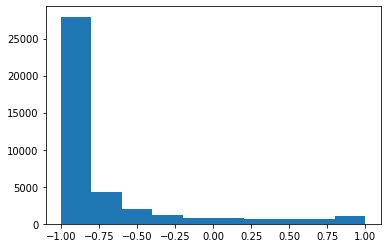

In [ ]:
plt.hist(preds.squeeze().cpu().numpy())

In [ ]:
(preds>0.5).sum()

tensor(2104)

In [ ]:
unweighted_profit(preds, y_true, )

tensor(0.1114)

### Workflow with Discrete Variables

In [ ]:
nrows=200000
df_main = pd.read_csv('./data/custom/bi_sample_anon.csv', nrows=nrows)

cols_c, cols_d, cols_y, n_train = get_discrete_config()
splits = TSSplitter()(df_main)



In [ ]:
df_small = df_main.iloc[:10000]
splits_small = TSSplitter()(df_small)



In [ ]:
def get_dls(df, cols_c, cols_y, splits, cols_d=None, bs=[256, 512]):
    '''
    create dataloaders
    '''
    if cols_d is not None:
        items, _ = df_to_items_discrete(df, [cols_c, cols_d], cols_y, n_train)
    else:
        items, _ = df_to_items(df, cols_c, cols_y, n_train)
        
    if cols_d: Xc,Xd,y = items_to_arrays(items)
    else: (Xc,y), Xd = items_to_arrays(items), None
    dsets = TSDatasets2(X=Xc, X_dis=Xd, y=y, splits=splits)
    ss = TSStandardize()
    return TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[128,512], batch_tfms=[ss])
    

In [ ]:
def _remove_augs(dls):
    '''
    remove augmentation transforms from dls.after_batch
    '''
    dls.after_batch = Pipeline([tfm for tfm in dls.after_batch if not issubclass(type(tfm), AugTransform)])

In [ ]:
dls.after_batch

Pipeline: TSStandardize -> Augmix

In [ ]:
_remove_augs(dls)

In [ ]:
dls.after_batch

Pipeline: TSStandardize

In [ ]:
def run_training(dls, arch, seed, n_epochs, max_lr, wd, loss_fn_name, alpha, metrics=unweighted_profit, 
                 N=2, magnitude=0.1, pct_start=0.3, div_factor=25.0):
    # model = ResNetSig(db.features, db.c).to(device)
    '''
    run a training cycle
    parameterization important for keeping track
    
    '''
    print(f'pct_start: {pct_start} div_factor: {div_factor}')
    set_seed(seed)
#     model = arch(db.features, db.c)
    model = arch(6,1)
    
    _remove_augs(dls)
    augs = RandAugment(N=N, magnitude=magnitude, verbose=True)
#     augs  = Augmix(verbose=True)
    dls.after_batch.add(augs)
        
    loss_fn = get_loss_fn(loss_fn_name, alpha=alpha)
    print(loss_fn)
    
    learn = Learner(dls, model, loss_func=loss_fn, metrics=metrics)
#     learn.loss_func = leaky_loss
    ## (6,10) dep='hc_result', InceptionTime
    learn.fit_one_cycle(n_epochs, max_lr, wd=wd, pct_start=pct_start, div_factor=div_factor)
#     learn.recorder.plot_losses()
#     learn.recorder.plot_metrics()
    return learn

In [ ]:
for i, p in enumerate(learn.dls.after_batch):
    print(i,p)

0 TSStandardize: (TSTensor,object) -> encodes
(NumpyTensor,object) -> encodes 
1 Augmix: (TSTensor,object) -> encodes 


In [ ]:
%time dls = get_dls(df_main, cols_c, cols_y, splits, cols_d=None)

(200000, 4, 10)
[<class 'torchtools.data.TSTensor'>, None]
[<class 'torchtools.data.TSTensor'>, None]
[<class 'torchtools.data.TSTensor'>, None]
CPU times: user 49.7 s, sys: 865 ms, total: 50.6 s
Wall time: 49.1 s


In [ ]:
%time dls = get_dls(df_small, cols_c, cols_y, splits_small, cols_d=cols_d)

(10000, 4, 10) (10000, 2, 10)
[<class 'torchtools.data.TSTensor'>, <class 'torchtools.data.TSIntTensor'>, None]
[<class 'torchtools.data.TSTensor'>, <class 'torchtools.data.TSIntTensor'>, None]
[<class 'torchtools.data.TSTensor'>, <class 'torchtools.data.TSIntTensor'>, None]
CPU times: user 3.61 s, sys: 6.3 ms, total: 3.61 s
Wall time: 3.63 s


In [ ]:
arch = InceptionTimeD
seed = 1234
n_epochs = 10
max_lr = 1e-5
loss_fn_name = 'leaky_loss'
wd = 0.03
alpha = 0.5

In [ ]:
dls.after_batch

Pipeline: TSStandardize -> Augmix

In [ ]:
dls.train.after_batch

Pipeline: TSStandardize -> Augmix

In [ ]:
learn = run_training(dls, arch, seed, n_epochs, max_lr, wd, loss_fn_name, alpha)

pct_start: 0.3 div_factor: 25.0
tfms None
functools.partial(<function leaky_loss at 0x7f4f082e38c0>, alpha=0.5)


epoch,train_loss,valid_loss,unweighted_profit,time
0,-0.114352,-0.478096,0.045991,00:05
1,-0.106994,-0.493204,-0.060021,00:05
2,-0.171666,-0.481824,0.071673,00:05
3,-0.138080,-0.487469,0.002594,00:05
4,-0.212245,-0.502662,-0.057732,00:05
5,-0.257199,-0.466987,0.047012,00:07
6,-0.308527,-0.447131,-0.327185,00:05
7,-0.300647,-0.484448,-0.150219,00:05
8,-0.290917,-0.457173,-0.018247,00:05
9,-0.313202,-0.456224,-0.081538,00:05


weights [0.12069069 0.55244944 0.32685987], m 0.4964742723937071
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
timenormal torch.Size([128, 4, 10])
ywarp
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ops in step 2 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
weights [0.12543808 0.72879941 0.14576251], m 0.2903342193318701
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
ywarp
timenormal torch.Size([128, 4, 10])
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ops in step 2 [TimeNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
weights [0.32536308 0.04528067 0.62935625], m 0.5590176479614829
ops in step 0

weights [0.79341402 0.13453959 0.0720464 ], m 0.1465281167911707
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
yscale
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
yscale
ops in step 2 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
weights [0.61745238 0.03776037 0.34478725], m 0.37422223317881353
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ops in step 2 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
weights [0.97893596 0.00701311 0.01405093], m 0.17153715120928284
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]

weights [0.30966499 0.63147015 0.05886487], m 0.725101691153681
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
ywarp
timewarp
timenormal torch.Size([128, 4, 10])
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ynormal
ops in step 2 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
weights [0.47706423 0.48891149 0.03402428], m 0.5646028718802175
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ywarp
ops in step 1 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
timewarp
ops in s

weights [0.10394198 0.68109752 0.2149605 ], m 0.9724278057231293
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
timewarp
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
timenormal torch.Size([128, 4, 10])
yscale
ops in step 2 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
weights [0.47670927 0.18759649 0.33569424], m 0.7296603133465388
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
timenormal torch.Size([128, 4, 10])
yscale
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTens

weights [0.46374034 0.52986631 0.00639335], m 0.9690593767510748
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
yscale
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ynormal
weights [0.09262792 0.70084831 0.20652377], m 0.9956718237828026
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
yscale
timenormal torch.Size([128, 4, 10])
ops in step 1 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
ops in step 2 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal


yscale
weights [0.28377202 0.6521544  0.06407359], m 0.18182765322556987
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ops in step 1 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
ynormal
timenormal torch.Size([128, 4, 10])
ops in step 2 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
weights [0.10950711 0.62608025 0.26441264], m 0.28869373673357557
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ynormal
ops in step 2 [TimeNormal: (TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ywarp
weights [0.23079984 0.38679792 0.38240223], m 0.6334876415161652
ops in s

weights [0.215345   0.43468792 0.34996708], m 0.3425194308659808
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
timenormal torch.Size([128, 4, 10])
ywarp
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ops in step 2 [TimeNormal: (TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ynormal
ywarp
weights [0.57314326 0.22581909 0.20103765], m 0.8815753682272621
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ywarp
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,ob

weights [0.52302501 0.10372086 0.37325413], m 0.6336477383556616
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
timewarp
yscale
ops in step 1 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
ops in step 2 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
ywarp
timewarp
timenormal torch.Size([128, 4, 10])
weights [0.31410425 0.03677865 0.6491171 ], m 0.9487818049408666
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
timewarp
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSInt

timenormal torch.Size([128, 4, 10])
ynormal
ops in step 2 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
ywarp
timenormal torch.Size([128, 4, 10])
weights [0.35423886 0.60268414 0.043077  ], m 0.2720385279562739
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ynormal
ops in step 1 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
ywarp
ops in step 2 [TimeNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
weights [0.23312142 0.38898439 0.37789419], m 0.49918373425178075
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ynormal
ops in step 1 [TimeWarp: (TSIntTensor,object) -> 

weights [0.05228531 0.06682271 0.88089198], m 0.8680888150254265
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ynormal
ywarp
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
timewarp
ops in step 2 [TimeNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
weights [0.58754672 0.23879511 0.17365817], m 0.9179136397560822
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ywarp
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ops in step 2 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes

weights [0.79548319 0.14093413 0.06358268], m 0.5158195366935509
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ywarp
yscale
ops in step 2 [TimeNormal: (TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ywarp
weights [0.41876838 0.14197033 0.43926129], m 0.3487553118146907
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
timenormal torch.Size([128, 4, 10])
ynormal
ops in step 2

weights [0.14998792 0.64434197 0.2056701 ], m 0.4924003852079255
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
timewarp
ops in step 1 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
yscale
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
timewarp
weights [0.3373149 0.6467485 0.0159366], m 0.04793454552833978
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ynormal
ops in step 2 [TimeNormal: (TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) 

weights [0.46612398 0.44460605 0.08926997], m 0.5572361741838711
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
weights [0.03579395 0.92943652 0.03476953], m 0.1353317376391322
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
yscale
timenormal torch.Size([128, 4, 10])
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
timenormal torch.Size([128, 4, 10])
yscale
ops in step 2 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
weights [0.31757997 0.02720053 0.6552195 ], m 0.6004192420455577
ops in

ops in step 2 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
timewarp
weights [0.09212396 0.85689039 0.05098565], m 0.16123575210788824
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
yscale
ywarp
ops in step 1 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
yscale
ynormal
timenormal torch.Size([128, 4, 10])
weights [0.07903157 0.82987886 0.09108956], m 0.8459062298810532
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,o

weights [0.25241908 0.73170801 0.01587291], m 0.5880701896770892
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ywarp
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
yscale
ynormal
timenormal torch.Size([128, 4, 10])
weights [0.31483334 0.31832593 0.36684074], m 0.12466501464680801
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
yscale
timenormal torch.Size([128, 4, 10])
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) ->

weights [0.75971095 0.00837332 0.23191573], m 0.42891759576113564
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
timewarp
ywarp
timenormal torch.Size([128, 4, 10])
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
yscale
timewarp
ops in step 2 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
weights [0.02481989 0.90803504 0.06714507], m 0.012289644165437453
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ywarp
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,obje

weights [0.06958438 0.59979431 0.33062131], m 0.07380221927068686
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
timewarp
timenormal torch.Size([128, 4, 10])
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
ywarp
timenormal torch.Size([128, 4, 10])
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ynormal
weights [0.13545709 0.11615091 0.74839201], m 0.31246810859157215
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ynormal
timewarp
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ops in s

weights [0.64213762 0.29946294 0.05839945], m 0.32504893171368143
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
timewarp
yscale
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ynormal
ops in step 2 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
timewarp
yscale
timenormal torch.Size([128, 4, 10])
weights [0.60877113 0.0034342  0.38779467], m 0.5064846254171573
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes


weights [0.03161883 0.23065626 0.73772492], m 0.8623653796515747
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
yscale
timewarp
timenormal torch.Size([128, 4, 10])
ops in step 2 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
weights [0.49911441 0.06392659 0.436959  ], m 0.9758204487410702
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ywarp
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ynormal
yscale
ops in step 

weights [0.13001119 0.57794619 0.29204262], m 0.3872543137138889
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ops in step 2 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ynormal
weights [0.06730651 0.92034834 0.01234515], m 0.09888773138652002
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
yscale
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
timewarp
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
weights [0.00316929 0.2199738  0.77685692], m 0.2614542188257285
ops in step 0 [

weights [0.88162979 0.08985995 0.02851026], m 0.61942083162258
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
timewarp
ynormal
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ops in step 2 [TimeNormal: (TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ynormal
weights [0.35270459 0.22481545 0.42247996], m 0.15624159686445682
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
yscale
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,obj

weights [0.09193983 0.29171694 0.61634324], m 0.37928167370842353
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ynormal
yscale
ops in step 1 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
yscale
ops in step 2 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
timenormal torch.Size([128, 4, 10])
timewarp
weights [0.36858221 0.43852901 0.19288878], m 0.9663717525783783
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ops in step 1 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
ops in s

timewarp
ops in step 2 [TimeNormal: (TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
yscale
ynormal
weights [0.59185675 0.03611142 0.37203183], m 0.38240933041625236
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ops in step 2 [TimeNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
weights [0.70667886 0.0509576  0.24236354], m 0.08132644425906169
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ynormal
ops in step 2 [TimeNormal: (TSTensor,object) -> encodes
 YNormal

weights [0.01275821 0.11644996 0.87079183], m 0.16103305469766813
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ywarp
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ops in step 2 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
timewarp
ywarp
timenormal torch.Size([128, 4, 10])
weights [0.07970547 0.80861565 0.11167888], m 0.2012712696078524
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
yscale
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,o

weights [0.01082097 0.97948214 0.00969689], m 0.41361513325390514
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ywarp
timewarp
ops in step 1 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
ops in step 2 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
ynormal
timenormal torch.Size([128, 4, 10])
weights [0.15116224 0.1705315  0.67830626], m 0.4296648250499976
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
ywarp
timewarp
timenormal torch.Size([128, 4, 10])
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTe

weights [0.02611231 0.08295023 0.89093746], m 0.8709435914336124
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ops in step 1 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
timewarp
ywarp
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
weights [0.29412165 0.01951403 0.68636432], m 0.923515714454148
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ops in step 2 [TimeNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
weights [0.02658286 0.40600257 0.56741457], m 0.7691629050636222
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes


weights [0.07430827 0.5788345  0.34685723], m 0.18153393489205577
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
yscale
timenormal torch.Size([128, 4, 10])
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ops in step 2 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
timewarp
weights [0.32509393 0.26594245 0.40896362], m 0.8070842980256258
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
timewarp
ywarp
timenormal torch.Size([128, 4, 10])
ops in step 2 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encode

weights [0.2335753 0.6926734 0.0737513], m 0.7448640620643503
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ynormal
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ynormal
yscale
ops in step 2 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
weights [0.40382786 0.47975855 0.11641359], m 0.5058218808573773
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
ynormal
timewarp
timenormal torch.Size([128, 4, 10])
ops in step 1 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (T

weights [0.10160658 0.02636909 0.87202433], m 0.49427191371184886
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
yscale
ops in step 1 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
ynormal
yscale
timenormal torch.Size([128, 4, 10])
ops in step 2 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ynormal
weights [0.15677351 0.20028044 0.64294604], m 0.7575405144915739
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,objec

yscale
weights [0.32834895 0.45630269 0.21534836], m 0.7671644834463526
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
timewarp
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
yscale
ops in step 2 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
yscale
weights [0.02489102 0.63600649 0.33910249], m 0.4482144598378966
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ywarp
yscale
ops in step 1 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNorm

weights [0.32311251 0.63358197 0.04330552], m 0.7985898978313843
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
yscale
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
ywarp
timenormal torch.Size([128, 4, 10])
ops in step 2 [TimeNormal: (TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ywarp
ynormal
weights [0.39074707 0.60630101 0.00295192], m 0.5947765150796317
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ops in step 1 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) ->

weights [0.74922547 0.10501311 0.14576142], m 0.18368535829352062
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
timewarp
yscale
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
timewarp
weights [0.02426455 0.13313125 0.8426042 ], m 0.6226313314154488
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
timenormal torch.Size([128, 4, 10])
ywarp
ops in step 1 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSI

weights [0.75428869 0.12836077 0.11735054], m 0.9801398059786272
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ynormal
ops in step 2 [TimeNormal: (TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
yscale
weights [0.35101303 0.41658013 0.23240684], m 0.8186893110687615
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ops in step 2 [TimeNormal: (TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
timewarp

weights [0.29960025 0.58648046 0.11391929], m 0.7808464578747517
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
timewarp
ywarp
ops in step 2 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
timewarp
ynormal
weights [0.00393787 0.08963089 0.90643124], m 0.010190047083753078
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
yscale
ynormal
ops in step 1 [YScale

weights [0.05336262 0.06097809 0.88565929], m 0.3257428444531192
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ywarp
timewarp
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ops in step 2 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
yscale
weights [0.64117109 0.02587652 0.33295239], m 0.1720627459037328
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
ynormal
ywarp
timenormal torch.Size([128, 4, 10])
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ops i

weights [0.35673688 0.27126046 0.37200266], m 0.9039617108966623
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ynormal
timewarp
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ynormal
weights [0.03876249 0.80046612 0.16077139], m 0.12967690252311068
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
yscale
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTens

ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ops in step 2 [TimeNormal: (TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
yscale
weights [0.0646299  0.1099747  0.82539539], m 0.501830210862461
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
yscale
ops in step 1 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
timewarp
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
yscale
timenormal torch.Size([128, 4, 10])
weights [0.0726394  0.76424946 0.16311115], m 0.059321156448765004
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeW

weights [0.17115814 0.01296962 0.81587223], m 0.5158761539717471
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
timewarp
ywarp
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
timewarp
yscale
ops in step 2 [TimeNormal: (TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
timewarp
yscale
weights [0.411467  0.0069571 0.5815759], m 0.7436081627081026
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> 

weights [0.16863545 0.15332215 0.6780424 ], m 0.8085811466174799
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ops in step 2 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ynormal
yscale
weights [0.68265982 0.03881411 0.27852607], m 0.06206393584567948
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ynormal
yscale
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ynormal
ops in step 2 [Y

weights [0.26904714 0.33618124 0.39477162], m 0.6706980782787232
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ynormal
timewarp
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ops in step 2 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
timenormal torch.Size([128, 4, 10])
yscale
weights [0.36616582 0.60631839 0.02751579], m 0.8544085208143606
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
yscale
ywarp
ops in step 1 [TimeNormal: (

weights [0.00165759 0.36085489 0.63748752], m 0.5587861046129552
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ops in step 2 [TimeNormal: (TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ywarp
yscale
weights [0.0595838  0.02208889 0.91832731], m 0.7491747400887989
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
timewarp
timenormal torch.Size([128, 4, 10])
ops in step 2 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
weights [0.49683619 0.3037325  0.19943131], m 0.7860272718751437
ops in step

weights [0.25040466 0.66056124 0.0890341 ], m 0.09091319976646907
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ops in step 2 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
timenormal torch.Size([128, 4, 10])
ywarp
weights [0.12411254 0.06777894 0.80810851], m 0.9790286924401737
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ynormal
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
weights [0.18497642 0.44170761 0.37331597], m 0.07372906105388773
ops i

weights [0.49928808 0.1998808  0.30083112], m 0.9346227680837496
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
timenormal torch.Size([128, 4, 10])
ynormal
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([128, 4, 10])
ywarp
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
timewarp
weights [0.4324572  0.24544326 0.32209954], m 0.4247360044766094
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ynormal
yscale
ops in step 1 [TimeWarp: (

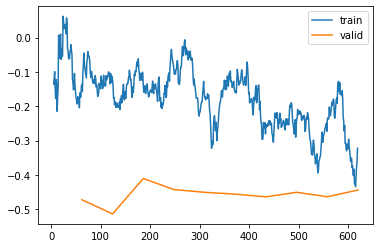

In [ ]:
learn.recorder.plot_loss()

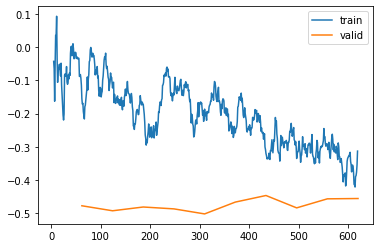

In [ ]:
learn.recorder.plot_loss()

In [ ]:
dls.after_batch

Pipeline: TSStandardize -> RandAugment

In [ ]:
dls.

Pipeline: 

In [ ]:
learn.dls.after_batch

Pipeline: TSStandardize -> Augmix

In [ ]:
augs = Augmix(verbose=True)

tfms None


In [ ]:
dls.after_batch.add(augs)

In [ ]:
dls.after_batch

Pipeline: TSStandardize -> Augmix

In [ ]:
get_dls(df_main, cols_c, cols_y, splits, cols_d=None)

(200000, 4, 10)


In [ ]:
TSs

In [ ]:
items, _ = df_to_items_discrete(df_main, [cols_c, cols_d], cols_y, n_train)
items, _ = df_to_items(df_main, cols_c, cols_y, n_train)

(200000, 4, 10) (200000, 2, 10)
(200000, 4, 10)


In [ ]:
Xc,Xd, y = items_to_arrays(items)

In [ ]:
*Xs, y = items_to_arrays(items)

In [ ]:
l = [1,2]

In [ ]:
x,y = l

In [ ]:
x,y

(1, 2)

In [ ]:
len(Xs)

1

In [ ]:
Xs[0].shape

(200000, 4, 10)

In [ ]:
Xc.shape, Xd.shape, y.shape

((200000, 4, 10), (200000, 2, 10), (200000,))

In [ ]:
def TSSplitter(train_perc=0.8):
    def _inner(o, **kwargs):
        return L(range(0, int(len(o)*train_perc))), L(range(int(len(o)*train_perc), len(o)))
    return _inner

In [ ]:
splits = TSSplitter()(df_main)
dsets = TSDatasets2(X=Xc, X_dis=Xd, y=y, splits=splits)

[<class 'torchtools.data.TSTensor'>, <class 'torchtools.data.TSIntTensor'>, None]


In [ ]:
ss = TSStandardize(by_var=True, verbose=True)
augs = Augmix()

tfms None


In [ ]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[128,512], batch_tfms=[ss, augs])

[<class 'torchtools.data.TSTensor'>, <class 'torchtools.data.TSIntTensor'>, None]
[<class 'torchtools.data.TSTensor'>, <class 'torchtools.data.TSIntTensor'>, None]
TSStandardize setup mean=None, std=None, by_sample=False, by_var=True
mean: tensor([[[-1.2892],
         [-1.5581],
         [-1.6429],
         [-1.9509]]])  std: tensor([[[86.9361],
         [89.8526],
         [86.2570],
         [89.8491]]])



In [ ]:
xbc, xbd, yb = dls[1].one_batch()

standardize encodes


In [ ]:
type(xbc), type(xbd), type(yb)

(torchtools.data.TSTensor, torchtools.data.TSIntTensor, torch.Tensor)

In [ ]:
model = InceptionTimeD(6,1)
loss_fn = get_loss_fn('leaky_loss', alpha=0.5)

In [ ]:
dls.after_batch = Pipeline(dls.fs[0])

In [ ]:
dls.after_batch = Pipeline([TSStandardize(), Augmix(verbose=True)])

tfms None


In [ ]:
dls.after_batch

Pipeline: TSStandardize -> Augmix

In [ ]:
learn = Learner(dls, model, loss_func=loss_fn)

In [ ]:
learn.dls.after_batch[1].tfms

[YWarp: (TSIntTensor,object) -> encodes
 (TSTensor,object) -> encodes , YNormal: (TSIntTensor,object) -> encodes
 (TSTensor,object) -> encodes , YScale: (TSIntTensor,object) -> encodes
 (TSTensor,object) -> encodes , TimeWarp: (TSIntTensor,object) -> encodes
 (TSTensor,object) -> encodes , TimeNormal: (TSTensor,object) -> encodes ]

In [ ]:
xb, xc, y = learn.dls.one_batch()

In [ ]:
xc

TSIntTensor([[[                   2,                    4,                   -1,
           ...,                    0,                    0,
                             0],
         [                  -1,                    1,                   -2,
           ...,                    1,                   -1,
                            -1]],

        [[                   1,                    2,                   -1,
           ...,                    1,                    0,
                            -1],
         [                   0,                    2,                   -6,
           ...,                    1,                    0,
                            -1]],

        [[                   0,                    1,                   -1,
           ...,                   -1,                    0,
                            -1],
         [                  -2,                    3,                    0,
           ...,                    2,                   -1,
          

In [ ]:
learn.dls.after_batch[1](xc)

TSIntTensor([[[                   0,                   -1,                   -2,
           ...,                    0,                    3,
                             0],
         [                  -1,                   -3,                    0,
           ...,                   -1,                   -2,
                             1]],

        [[                   0,                   -1,                    1,
           ..., -9223372036854775808, -9223372036854775808,
          -9223372036854775808],
         [                   1,                    3,                   -1,
           ...,                   -2,                   -2,
                            -1]],

        [[                   0,                   -2,                    2,
           ..., -9223372036854775808, -9223372036854775808,
          -9223372036854775808],
         [                  -2,                   -2,                   -3,
           ..., -9223372036854775808, -9223372036854775808,
          

In [ ]:
#cuda
max_lr = 1e-5
epochs = 1
learn.fit_one_cycle(epochs, max_lr=max_lr)

epoch,train_loss,valid_loss,time
0,-0.237933,-0.289135,00:04


InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
InceptionTimeSgm dtype torch.float32
I

In [ ]:
preds = learn.get_preds()

standardize encodes


standardize encodes
InceptionTimeSgm dtype torch.float32
standardize encodes
InceptionTimeSgm dtype torch.float32
standardize encodes
InceptionTimeSgm dtype torch.float32
standardize encodes
InceptionTimeSgm dtype torch.float32
standardize encodes
InceptionTimeSgm dtype torch.float32
standardize encodes
InceptionTimeSgm dtype torch.float32
standardize encodes
InceptionTimeSgm dtype torch.float32
standardize encodes
InceptionTimeSgm dtype torch.float32
standardize encodes
InceptionTimeSgm dtype torch.float32
standardize encodes
InceptionTimeSgm dtype torch.float32
standardize encodes
InceptionTimeSgm dtype torch.float32
standardize encodes
InceptionTimeSgm dtype torch.float32
standardize encodes
InceptionTimeSgm dtype torch.float32
standardize encodes
InceptionTimeSgm dtype torch.float32
standardize encodes
InceptionTimeSgm dtype torch.float32
standardize encodes
InceptionTimeSgm dtype torch.float32
standardize encodes
InceptionTimeSgm dtype torch.float32
standardize encodes
InceptionTi

In [ ]:
preds, y_true = preds

In [ ]:
(preds>0).sum()

tensor(1068)

In [ ]:
preds.shape

torch.Size([40000, 1])

In [ ]:
unweighted_profit(preds, y_true, -.2)

tensor(-0.0413)

(array([38932.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1068.]),
 array([-0.924294  , -0.7318646 , -0.5394352 , -0.34700578, -0.15457639,
         0.037853  ,  0.2302824 ,  0.4227118 ,  0.6151412 ,  0.8075706 ,
         1.        ], dtype=float32),
 <a list of 10 Patch objects>)

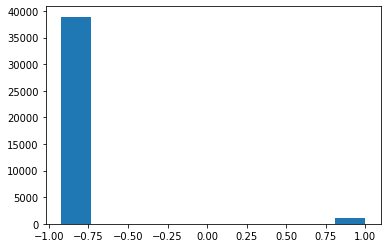

In [ ]:
plt.hist(preds.squeeze().cpu())

In [ ]:
preds

tensor([[-0.9243],
        [-0.9243],
        [ 1.0000],
        ...,
        [-0.9243],
        [-0.9243],
        [-0.9243]])